In [1]:
import numpy as np
import pandas as pd
import scipy.stats as spstats
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
import json
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import pytz
from dateutil.parser import parse
import skimage
from skimage import io
import re
import nltk
import warnings
# Ignore useless warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Avoid runtime error messages
pd.set_option('display.float_format', lambda x:'%f'%x)

# Always show numbers as floats, not in scientific notation
np.set_printoptions(suppress=True)
pt = np.get_printoptions()['threshold']

# make notebook's output stable across runs
np.random.seed(42)

# style
# plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_FOLDER = "housing_prices"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", PROJECT_FOLDER)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

<Figure size 1600x800 with 0 Axes>

In [ ]:
'''
# Matplotlib Summary

# set figure size (width, height)
plt.figure(figsize = [10, 5])

# Create subplots
# creates a new Axes in our Figure, its size determined by the subplot() function arguments. The first two arguments says to divide the figure into one row and two columns, and the third argument says to create a new Axes in the first slot. Slots are numbered from left to right in rows from top to bottom. Note in particular that the index numbers start at 1 (rather than the usual Python indexing starting from 0).
# subplot 1: example of somewhat too-large bin size
plt.subplot(1, 2, 1) # 1 row, 2 cols, subplot 1
bin_edges = np.arange(0, df['num_var'].max()+4, 4)
plt.hist(data = df, x = 'num_var', bins = bin_edges)

# subplot 2: example of somewhat too-small bin size
plt.subplot(1, 2, 2) # 1 row, 2 cols, subplot 2
bin_edges = np.arange(0, df['num_var'].max()+1/4, 1/4)
plt.hist(data = df, x = 'num_var', bins = bin_edges)

# Creating a bunch of subplots
fig, axes = plt.subplots(3, 4) # grid of 3x4 subplots
axes = axes.flatten() # reshape from 3x4 array into 12-element vector
for i in range(12):
    plt.sca(axes[i]) # set the current Axes
    # do something with the current axis.. in this case print the index number in the middle of the axis
    plt.text(0.5, 0.5, i+1)

# Move legend outside the chart
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
'''

# EDA

## Train-Test Split

In [ ]:
'''
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["label_column"]):
    train = df.loc[train_index]
    test = df.loc[test_index]

fetch_dir = 'data/'+PROJECT_FOLDER
fetch_from = fetch_dir+'/train.csv'
train.to_csv(fetch_from)
fetch_from = fetch_dir+'/test.csv'
test.to_csv(fetch_from)
'''

'''
# If label_column is a continuous int, convert it into categories/strata to use in StratifiedShuffleSplit above
df["label_column"] = pd.cut(df["label_int"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
df["label_column"].hist()
'''

## Fetch Data

In [2]:
# CSV
fetch_from = 'data/'+PROJECT_FOLDER+'/train.csv'
train = pd.read_csv(fetch_from)

fetch_from = 'data/'+PROJECT_FOLDER+'/test.csv'
test = pd.read_csv(fetch_from)

In [ ]:
# Zip File
import zipfile
# Extract all contents from zip file
with zipfile.ZipFile('file.zip', 'r') as myzip:
    myzip.extractall()

In [ ]:
# Reading TSV files
df = pd.read_csv('bestofrt.tsv',sep='\t')

In [ ]:
# Pickle file
df = pd.read_pickle('adataset.pkl')

In [ ]:
# H5 file
with pd.HDFStore('../input/madrid.h5') as data:
    df = data['master']

### JSON

In [ ]:
# JSON
df = pd.read_json('patients.json')

In [64]:
def print_nested_dicts(nested_dict,indent_level=0):
    """This function prints a nested dict object
    Args:
        nested_dict (dict): the dictionary to be printed
        indent_level (int): the indentation level for nesting
    Returns:
        None

    """
    
    for key, val in nested_dict.items():
        if isinstance(val, dict):
          print("{0} : ".format(key))
          print_nested_dicts(val,indent_level=indent_level+1)
        elif isinstance(val,list):
            print("{0} : ".format(key))
            for rec in val:
                print_nested_dicts(rec,indent_level=indent_level+1)
        else:
          print("{0}{1} : {2}".format("\t"*indent_level,key, val))

def extract_json(file_name,do_print=True):
    """This function extracts and prints json content from a given file
    Args:
        file_name (str): file path to be read
        do_print (bool): boolean flag to print file contents or not

    Returns:
        None

    """
    try:
        json_filedata = open(file_name).read() 
        json_data = json.loads(json_filedata)
        
        if do_print:
            print_nested_dicts(json_data)
    except IOError:
        raise IOError("File path incorrect/ File not found")
    except ValueError:
        ValueError("JSON file has errors")
    except Exception:
        raise

def extract_pandas_json(file_name,orientation="records",do_print=True):
    """This function extracts and prints json content from a file using pandas
       This is useful when json data represents tabular, series information
    Args:
        file_name (str): file path to be read
        orientation (str): orientation of json file. Defaults to records
        do_print (bool): boolean flag to print file contents or not

    Returns:
        None

    """
    try:
        df = pd.read_json(file_name,orient=orientation)
        
        if do_print:
            print(df)
    except IOError:
        raise IOError("File path incorrect/ File not found")
    except ValueError:
        ValueError("JSON file has errors")
    except Exception:
        raise

In [66]:
# Parse using pandas - pandas reads a JSON and prepares a tabular dataframe
extract_pandas_json('pandas_json.json')

# Parse using json module - generates a nested output resembling the structure of the JSON itself where outer_col_1's value is a nested object in itself
extract_json('sample_json.json')

  col_1 col_2
0     a     b
1     c     d
2     e     f
3     g     h
4     i     j
5     k     l
outer_col_1 : 
	nested_inner_col_1 : val_1
	nested_inner_col_2 : 2
	nested_inner_col_1 : val_2
	nested_inner_col_2 : 2
outer_col_2 : 
	inner_col_1 : 3
outer_col_3 : 4


In [ ]:
# Downloading Files From The Internet

# response.contents is in bytes format, not text, therefore we need to open the file in 'wb' (write binary) mode.
import requests
import os
# Make directory if it doesn't already exist
folder_name = 'ebert_reviews'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

ebert_review_urls = ['https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9900_1-the-wizard-of-oz-1939-film/1-the-wizard-of-oz-1939-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9901_2-citizen-kane/2-citizen-kane.txt']

# Implement the code in the video above in a for loop for all Ebert reviews
for url in ebert_review_urls:
    response = requests.get(url)
    # print (response.content)
    with open(os.path.join(folder_name,url.split('/')[-1]), mode="wb") as file:
        file.write(response.content)

In [ ]:
# Character Encodings

# look at the first ten thousand bytes to guess the character encoding
import chardet
with open("../input/kickstarter-projects/ks-projects-201801.csv", 'rb') as rawdata:
    enc = chardet.detect(rawdata.read(10000))

# check what the character encoding might be
print(enc)

# read in the file with the encoding detected by chardet
kickstarter_2016 = pd.read_csv("../input/kickstarter-projects/ks-projects-201612.csv", encoding=enc)

In [ ]:
# Write to CSV
kickstarter_2016.to_csv("train.csv")

# Write to pickle file
df.to_pickle("adataset_clean.pkl")

## Overview of training and test datasets

In [10]:
train.shape

(1460, 81)

In [11]:
test.shape

(1459, 80)

In [12]:
train[:5]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [13]:
test[:5]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [15]:
train.sample()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
892,893,20,RL,70.000000,8414,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2006,WD,Normal,154500


In [16]:
test.sample()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1084,2545,50,RL,74.000000,16287,Pave,NaN,Reg,Lvl,AllPub,...,100,0,NaN,NaN,NaN,0,7,2007,WD,Normal


In [17]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [18]:
test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


Saving figure feature_histogram_plots


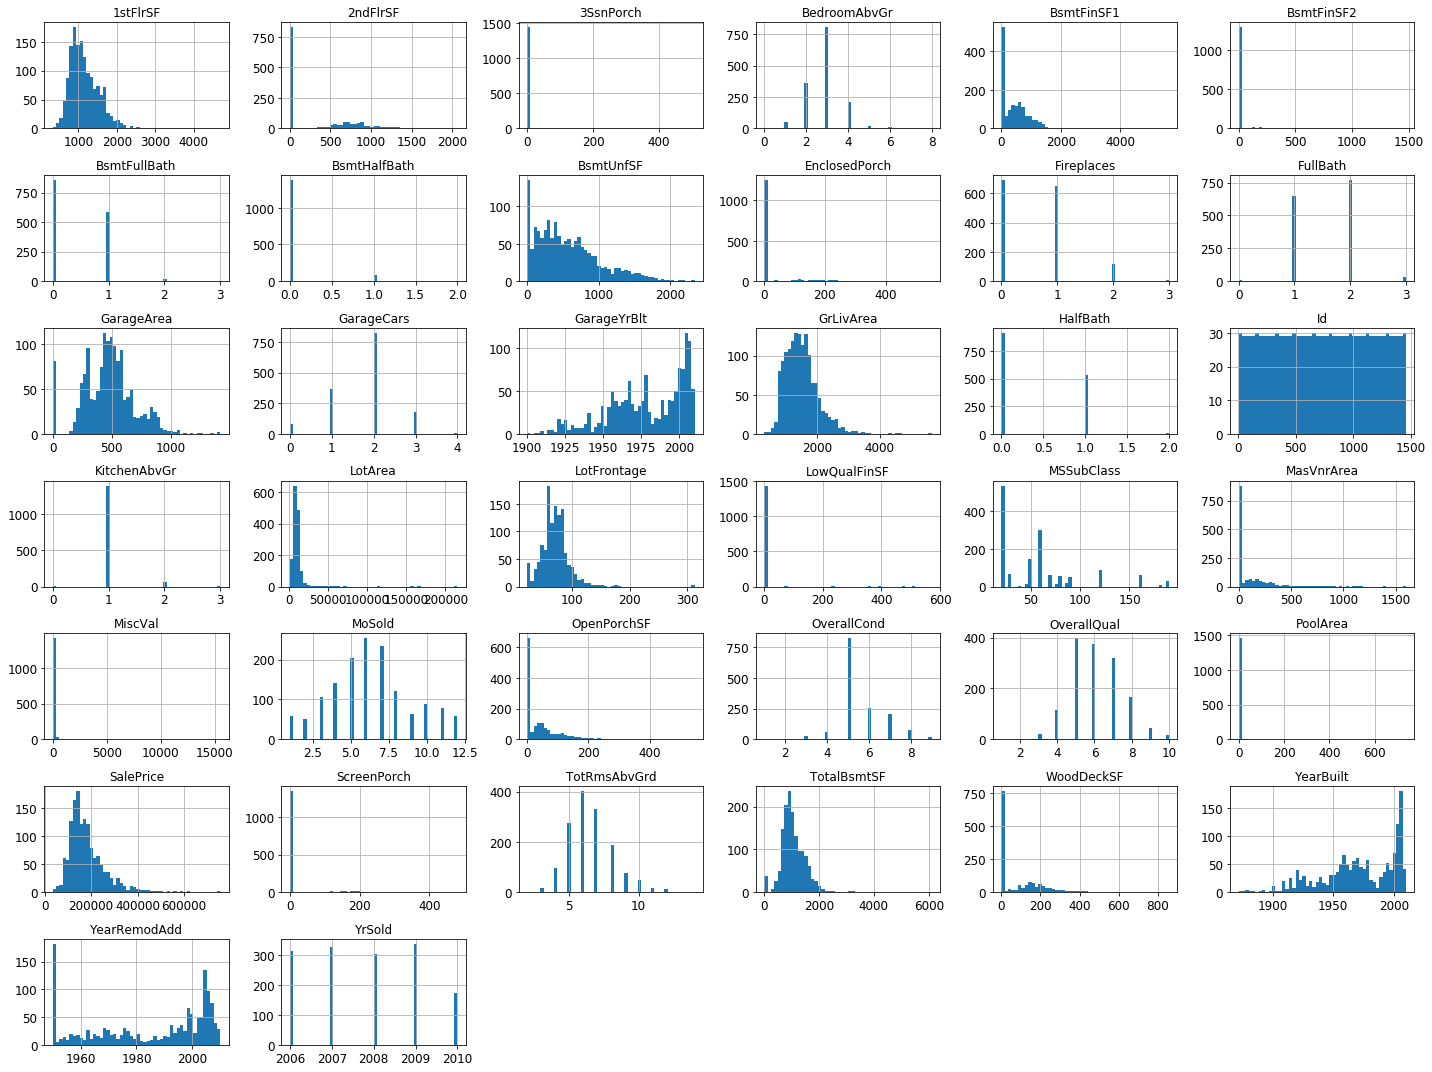

In [19]:
train.hist(bins=50, figsize=(20,15))
plt.tight_layout(pad=0.4)
save_fig("feature_histogram_plots")
plt.show()

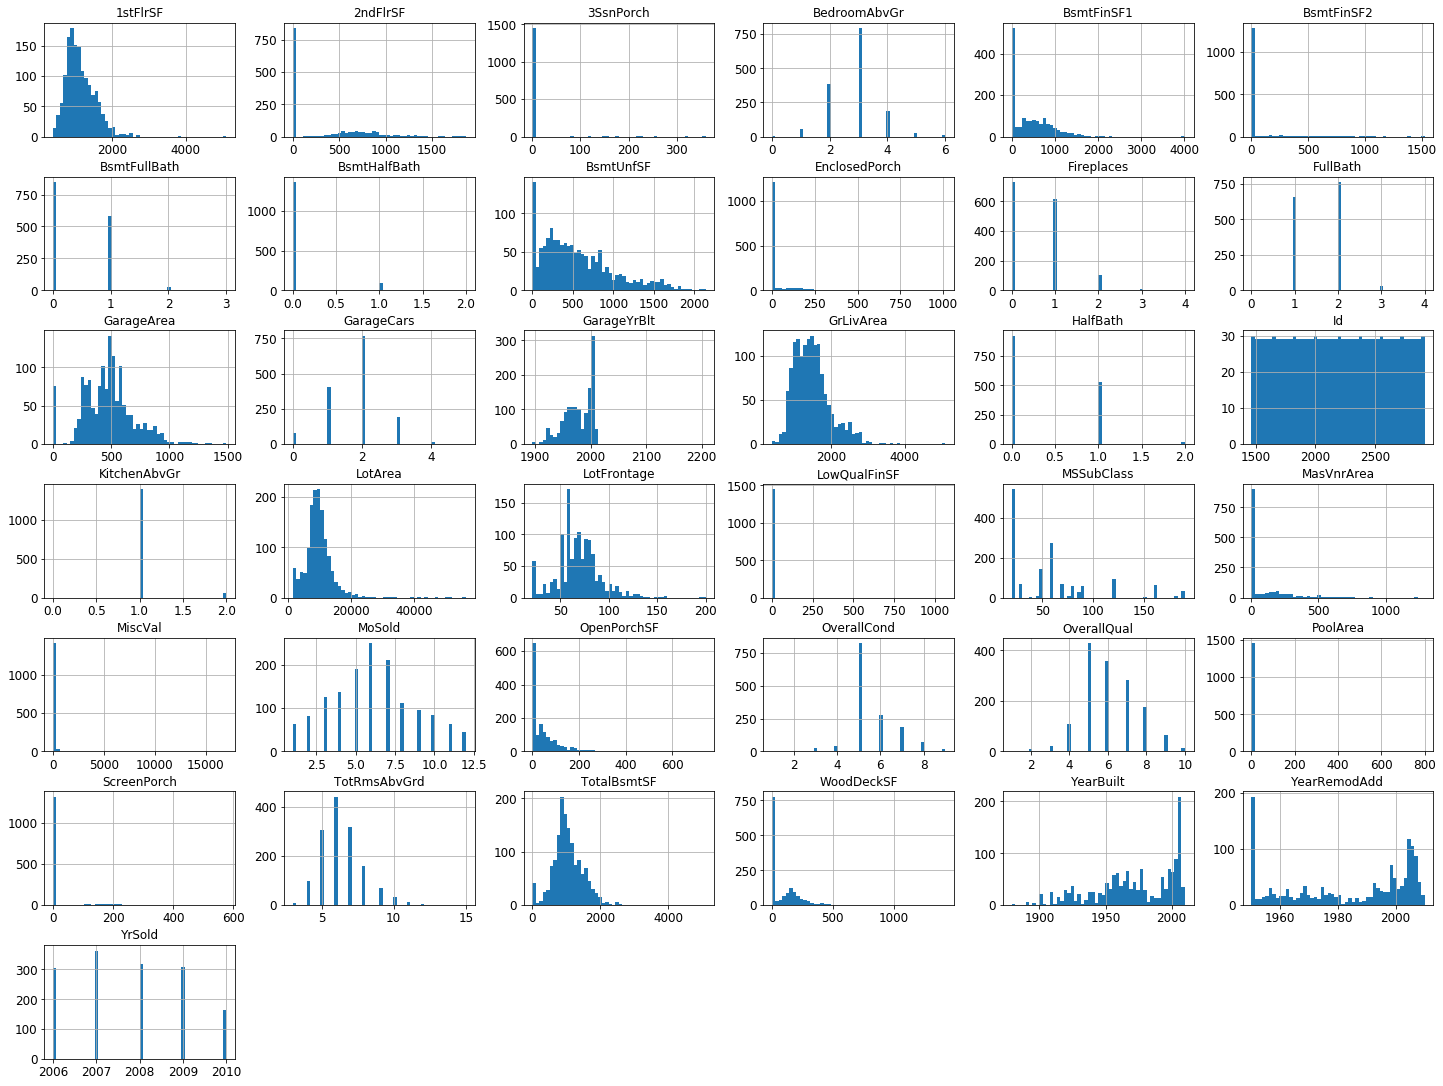

In [20]:
test.hist(bins=50, figsize=(20,15))
plt.tight_layout(pad=0.4)
plt.show()

In [21]:
train.describe(include='O')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [22]:
test.describe(include='O')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1455,1459,107,1459,1459,1457,1459,1459,1459,1459,...,1383,1381,1381,1381,1459,3,290,51,1458,1459
unique,5,2,2,4,4,1,5,3,25,9,...,6,3,4,5,3,2,4,3,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,1114,1453,70,934,1311,1457,1081,1396,218,1251,...,853,625,1293,1328,1301,2,172,46,1258,1204


## Deeper Dive Into Dataset

### Random Sampling data from DataFrame

In [33]:
display(train.sample(frac=0.2, replace=True, random_state=42).head())

,date,price,product_id,quantity_purchased,serial_no,user_id,user_type,user_class,purchase_week,encoded_user_type
102,2016-01-28,429.29,625,33,1102,5240,d,loyal_existing,4,3.0
435,2016-01-25,1068.73,1067,41,1435,5943,b,new,4,1.0
860,2016-08-02,5952.59,320,39,1860,5024,c,existing,31,2.0
270,2016-12-01,1158.08,405,25,1270,5759,c,existing,48,2.0
106,2016-08-02,2207.99,572,41,1106,5661,b,new,31,1.0


### Data Summarization

Condition based aggregation

In [38]:
print("Mean price of items purchased by user_type=a :: {}".format(df['price'][df['user_type']=='a'].mean()))

Mean price of items purchased by user_type=a :: 2441.0280995475105


Condtion based counts

In [39]:
print(df['purchase_week'].value_counts())

3     172
4     166
2     101
39     53
35     50
26     50
22     46
9      46
53     45
13     45
31     41
44     39
5      39
0      31
17     27
48     27
18     22
Name: purchase_week, dtype: int64


### Group By

Group By certain attributes

In [40]:
print(df.groupby(['user_class'])['quantity_purchased'].sum())

user_class
error              565
existing          5299
loyal_existing    5211
new               9988
Name: quantity_purchased, dtype: int32


Group By with different aggregate functions

In [41]:
display(df.groupby(['user_class'])['quantity_purchased'].agg([np.sum,
                                                                np.mean,
                                                                np.count_nonzero]))

,sum,mean,count_nonzero
user_class,,,
error,565,18.225806,31
existing,5299,20.699219,256
loyal_existing,5211,21.533058,242
new,9988,21.205945,471


Group by specific aggregate functions for each attribute

In [42]:
display(df.groupby(['user_class','user_type']).agg({'price':np.mean,
                                                        'quantity_purchased':np.max}))

quantity_purchased        price
user_class     user_type                                 
error          n                          40  2355.328710
existing       c                          41  2502.277358
loyal_existing d                          41  2349.236695
new            a                          41  2441.028100
               b                          41  2592.225064

Group by with multiple agg for each attribute

In [43]:
display(df.groupby(['user_class','user_type']).agg({'price':{
                                                                'total_price':np.sum,
                                                                'mean_price':np.mean,
                                                                'variance_price':np.std,
                                                                'count':np.count_nonzero},
                                                   'quantity_purchased':np.sum}))  

C:\Anaconda2\envs\python3\lib\site-packages\pandas\core\groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


quantity_purchased  price                             \
                                        sum  count total_price variance_price   
user_class     user_type                                                        
error          n                        565   31.0    73015.19    1286.420840   
existing       c                       5299  256.0   615560.23    1692.473899   
loyal_existing d                       5211  242.0   554419.86    1689.976272   
new            a                       4752  229.0   539467.21    1530.875030   
               b                       5236  242.0   609172.89    1746.481212   

                                       
                           mean_price  
user_class     user_type               
error          n          2355.328710  
existing       c          2502.277358  
loyal_existing d          2349.236695  
new            a          2441.028100  
               b          2592.225064

### Missing Values

#### How many missing values?

In [7]:
train.isnull().sum().sum()

6965

#### Top n columns with the most missing values

In [6]:
# Top n columns
n = 5
missing_values_count = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending=False)
missing_values_count[:n]

PoolQC        99.520548
MiscFeature   96.301370
Alley         93.767123
Fence         80.753425
FireplaceQu   47.260274
dtype: float64

#### Columns missing over 75%

In [5]:
cols_missing_over_75 = train.columns[train.isnull().mean() > 0.75]
cols_missing_over_75

Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

#### Table of columns with missing values

In [25]:
def missing_data(df):
    total = df.isnull().sum()
    percent = (df.isnull().sum()/train.isnull().count()*100)
    missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in df.columns:
        dtype = str(df[col].dtype)
        types.append(dtype)
    missing_values['Types'] = types
    missing_values.sort_values('Total',ascending=False,inplace=True)
    return(np.transpose(missing_values))
missing_data(train)

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageYrBlt,GarageCond,GarageType,GarageFinish,...,BsmtUnfSF,BsmtFinSF1,RoofStyle,Foundation,ExterCond,ExterQual,Exterior2nd,Exterior1st,RoofMatl,SalePrice
Total,1453,1406,1369,1179,690,259,81,81,81,81,...,0,0,0,0,0,0,0,0,0,0
Percent,99.520548,96.301370,93.767123,80.753425,47.260274,17.739726,5.547945,5.547945,5.547945,5.547945,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Types,object,object,object,object,object,float64,float64,object,object,object,...,int64,int64,object,object,object,object,object,object,object,int64


#### Plot of columns with missing values

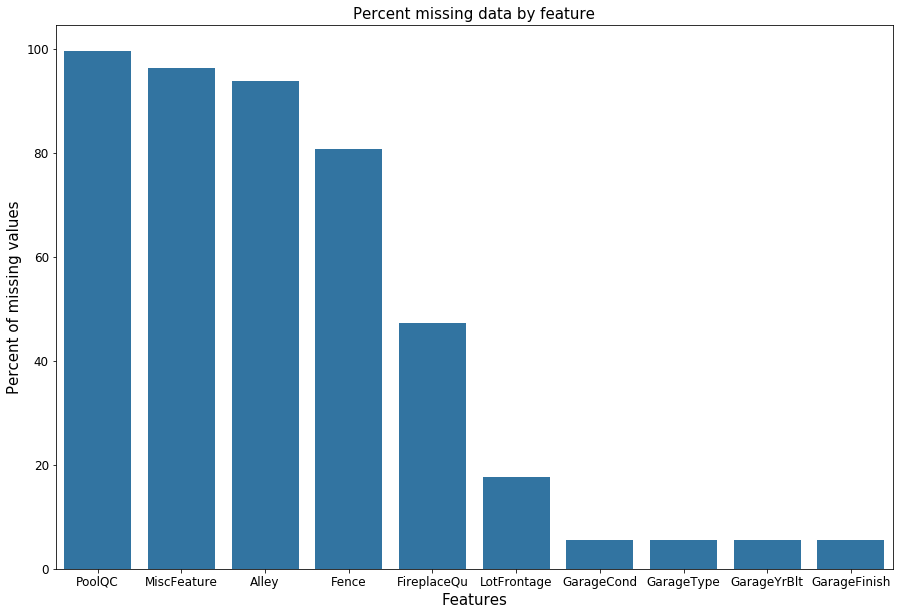

In [26]:
# Plot missing values vs column_names
# The 1st argument contains the x-values (column names), the 2nd argument the y-values (missing counts)
missing_values_count = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending=False)
plt.figure(figsize=(15,10))
base_color = sns.color_palette()[0]
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
sns.barplot(missing_values_count[:10].index.values, missing_values_count[:10], color = base_color)

### Outliers

In [27]:
# get all numerical columns
df_num = train.select_dtypes(include=[np.number]).columns.tolist()
df_num

# Calculate modified z_score
for col in df_num:
    df_outliers = train[(np.abs(train[col]-train[col].median()) > (3.5*train[col].mad()))]

# Uncomment to show outliers
# df_outliers

### Duplicated Values

In [28]:
# See if there's any duplicate values(cause of nicknames/misspellings/multiple ways of expressing a value), or default 'John Doe' type values
for col in train:
    train[train[col].duplicated()]


In [35]:
features_train = train.columns.values
features_test = test.columns.values
unique_max_train = []
unique_max_test = []
for feature in features_train:
    values = train[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
for feature in features_test:
    values = test[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

# top 15 max of duplicate values per train set
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

# top 15 number of duplicates values per test set
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,9,5,71,69,39,45,14,22,75,11,52,48,41,55,42
Feature,Utilities,Street,PoolArea,3SsnPorch,Heating,LowQualFinSF,Condition2,RoofMatl,MiscVal,LandSlope,KitchenAbvGr,BsmtHalfBath,CentralAir,Functional,Electrical
Max duplicates,1457,1453,1453,1446,1446,1445,1444,1442,1408,1396,1393,1364,1358,1357,1337
Value,AllPub,Pave,0,0,GasA,0,Norm,CompShg,0,Gtl,1,0.000000,Y,Typ,SBrkr


## Exploring Features

### Summary

**Things to look for during EDA**

- Check each column is a variable, and each row is an individual observation.
- Look at the number of rows and columns in the dataset.
- Check if there are missing values in any of the rows or columns.
- Check if any columns are of different data types than you would expect (ex: numbers showing as strings)
- Build exploratory plots like bar charts, histograms, and scatterplots to better understand the data.
- value_counts for all categorical features that look important, with accompanying bar charts
- Create a binary derived attribute (a tag) using map and plot differences in the values of a categorical variable by tag value of a row


In [36]:
train_eda = train.copy()

In [37]:
label_col = 'SalePrice'

### Correlations

In [38]:
# Pearson correlation
train_eda.corr()

# Kendall Tau correlation
train_eda.corr('kendall')

# Spearman Rank correlation
train_eda.corr('spearman')

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.019226,-0.033335,-0.005364,-0.028771,0.003622,-0.005130,-0.011680,-0.035507,-0.013038,...,-0.043239,-0.003225,-0.006758,-0.036706,0.005962,0.055555,-0.043383,0.019018,0.001526,-0.018546
MSSubClass,0.019226,1.000000,-0.314265,-0.269570,0.108065,-0.071770,0.035848,0.006802,0.025035,-0.107629,...,0.023370,0.031900,0.011023,-0.035830,-0.021673,0.033250,-0.032840,0.018403,-0.027401,0.007192
LotFrontage,-0.033335,-0.314265,1.000000,0.649633,0.254952,-0.083242,0.194510,0.116772,0.258906,0.154014,...,0.109288,0.178073,-0.095811,0.063960,0.043849,0.084534,0.024198,0.025758,0.003461,0.409076
LotArea,-0.005364,-0.269570,0.649633,1.000000,0.233303,-0.046912,0.103385,0.075158,0.177539,0.171995,...,0.184285,0.176965,-0.066563,0.062282,0.092316,0.084460,0.059297,0.006423,-0.027473,0.456461
OverallQual,-0.028771,0.108065,0.254952,0.233303,1.000000,-0.177521,0.647392,0.557723,0.413500,0.132957,...,0.259439,0.435046,-0.162434,0.032903,0.046335,0.056667,-0.088019,0.061455,-0.025464,0.809829
OverallCond,0.003622,-0.071770,-0.083242,-0.046912,-0.177521,1.000000,-0.416964,-0.041464,-0.179187,-0.011087,...,-0.042662,-0.133284,0.109749,0.032384,0.074728,-0.005605,0.086625,-0.007203,0.050214,-0.129325
YearBuilt,-0.005130,0.035848,0.194510,0.103385,0.647392,-0.416964,1.000000,0.684388,0.402349,0.189645,...,0.287729,0.392691,-0.408622,0.022498,-0.073119,0.008986,-0.091786,0.018621,-0.014100,0.652682
YearRemodAdd,-0.011680,0.006802,0.116772,0.075158,0.557723,-0.041464,0.684388,1.000000,0.234333,0.063353,...,0.230241,0.353325,-0.235037,0.051694,-0.045808,0.002821,-0.090868,0.021081,0.045158,0.571159
MasVnrArea,-0.035507,0.025035,0.258906,0.177539,0.413500,-0.179187,0.402349,0.234333,1.000000,0.241565,...,0.173736,0.208681,-0.179589,0.040997,0.038171,0.004863,-0.050279,0.017732,0.000552,0.421309
BsmtFinSF1,-0.013038,-0.107629,0.154014,0.171995,0.132957,-0.011087,0.189645,0.063353,0.241565,1.000000,...,0.179359,0.081420,-0.148339,0.046802,0.071989,0.057586,0.005097,-0.016405,0.020793,0.301871


In [39]:
corr_matrix = train_eda.corr()
corr_matrix[label_col].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

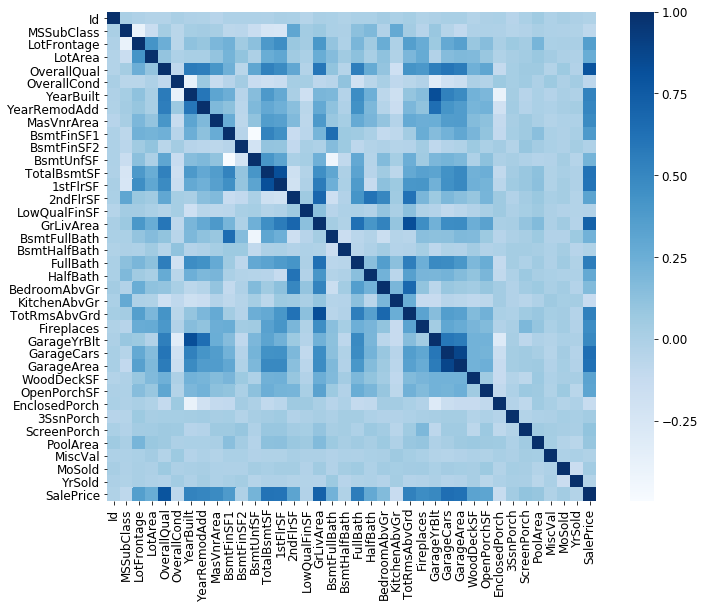

In [40]:
plt.subplots(figsize=(12,9))
sns.heatmap(corr_matrix, vmax=1.0, square=True, cmap="Blues")

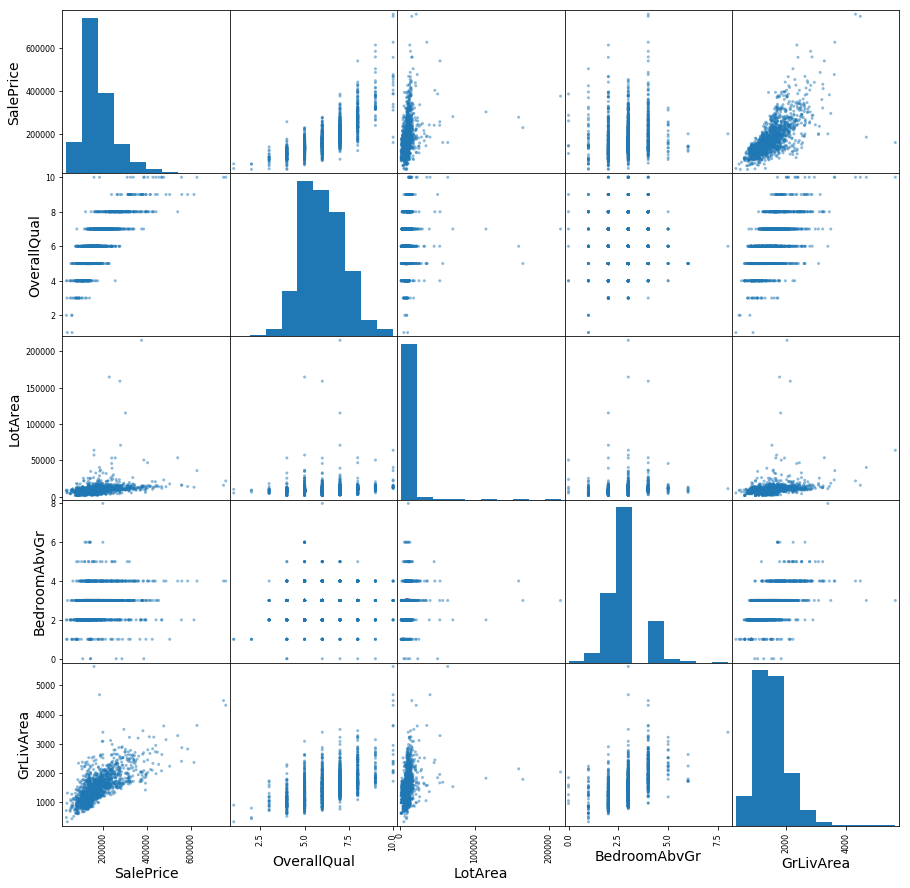

In [41]:
from pandas.plotting import scatter_matrix

attributes = [label_col, "OverallQual", "LotArea", "BedroomAbvGr", "GrLivArea"]
scatter_matrix(train_eda[attributes], figsize=(15, 15));

### Dataset Distributions

#### Density plots of features

In [ ]:
# We represent with different colors the distribution for values with target value 0 and 1.
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

In [ ]:
# create plots for the first 100 features
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[:101]
plot_feature_distribution(t0, t1, '0', '1', features)

In [ ]:
# distribution of the same features in parallel in train and test datasets
features = train_df.columns.values[:101]
plot_feature_distribution(train, test, 'train', 'test', features)

#### Distributions of mean and std for test vs training sets

In [ ]:
# distribution of the mean values per row in the train and test set
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train_df[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

In [ ]:
# distribution of the mean values per columns in the train and test set
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train_df[features].mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

In [ ]:
# distribution of standard deviation of values per row for train and test datasets
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train_df[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

In [ ]:
# distribution of the standard deviation of values per columns in the train and test datasets
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train_df[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

In [ ]:
# distribution of the mean value per row in the train dataset, grouped by value of target
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

In [ ]:
# distribution of the mean value per column in the train dataset, grouped by value of target
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

#### Distribution of min and max

In [ ]:
# distribution of min per row in the train and test set
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of min values per row in the train and test set")
sns.distplot(train_df[features].min(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].min(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

In [ ]:
# distribution of min per column in the train and test set
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of min values per column in the train and test set")
sns.distplot(train_df[features].min(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].min(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

In [ ]:
# distribution of max values per rows for train and test set
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of max values per row in the train and test set")
sns.distplot(train_df[features].max(axis=1),color="brown", kde=True,bins=120, label='train')
sns.distplot(test_df[features].max(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

In [ ]:
# distribution of max values per column for train and test set
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of max values per column in the train and test set")
sns.distplot(train_df[features].max(axis=0),color="blue", kde=True,bins=120, label='train')
sns.distplot(test_df[features].max(axis=0),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

In [ ]:
# distributions of min values per row in train set, separated on the values of target (0 and 1)
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[features].min(axis=1),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

In [ ]:
# distribution of min values per columns in train set
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[features].min(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

In [ ]:
# distribution of max values per rown in the train set
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[features].max(axis=1),color="gold", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

In [ ]:
# distribution of max values per columns in the train set
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[features].max(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

#### Distribution of skew and kurtosis

In [ ]:
# distribution of skewness calculated per rows in train and test sets
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per row in the train and test set")
sns.distplot(train_df[features].skew(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].skew(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

In [ ]:
# distribution of skewness calculated per columns in train and test set
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per column in the train and test set")
sns.distplot(train_df[features].skew(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].skew(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

In [ ]:
# distribution of kurtosis calculated per rows in train and test sets
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per row in the train and test set")
sns.distplot(train_df[features].kurtosis(axis=1),color="darkblue", kde=True,bins=120, label='train')
sns.distplot(test_df[features].kurtosis(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

In [ ]:
# distribution of kurtosis calculated per columns in train and test sets
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per column in the train and test set")
sns.distplot(train_df[features].kurtosis(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend()
plt.show()

In [ ]:
# distribution of skewness on rows in train separated for values of target 0 and 1
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

In [ ]:
# distribution of skewness on columns in train separated for values of target 0 and 1
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per column in the train set")
sns.distplot(t0[features].skew(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

In [ ]:
# distribution of kurtosis on rows in train separated for values of target 0 and 1
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per row in the train set")
sns.distplot(t0[features].kurtosis(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

In [ ]:
# distribution of kurtosis on columns in train separated for values of target 0 and 1
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per column in the train set")
sns.distplot(t0[features].kurtosis(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

### Target variable vs other features

#### SQL-like query on dataframe

In [ ]:
pd.DataFrame(train.query("Professional == 'Professional developer' and (Gender == 'Male' or Gender == 'Female')").groupby(['Gender', 'FormalEducation']).mean()['Salary'])

#### Categorical Variables

In [42]:
train_eda.describe(include='O')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


##### Frequency Table

In [43]:
# get freq table and proportions in one table
col_name = 'LotShape'
freq_table = pd.crosstab(index=train_eda[col_name],  # Make a crosstab
                              columns="count")      # Name the count column
freq_table_per = pd.crosstab(index=train_eda[col_name],  # Make a crosstab
                              columns="percentage", normalize=True)
freq_table['percentage'] = freq_table_per['percentage']
freq_table.sort_values(by='count', ascending=False)

col_0,count,percentage
LotShape,,
Reg,925,0.633562
IR1,484,0.331507
IR2,41,0.028082
IR3,10,0.006849


##### Bar Plot

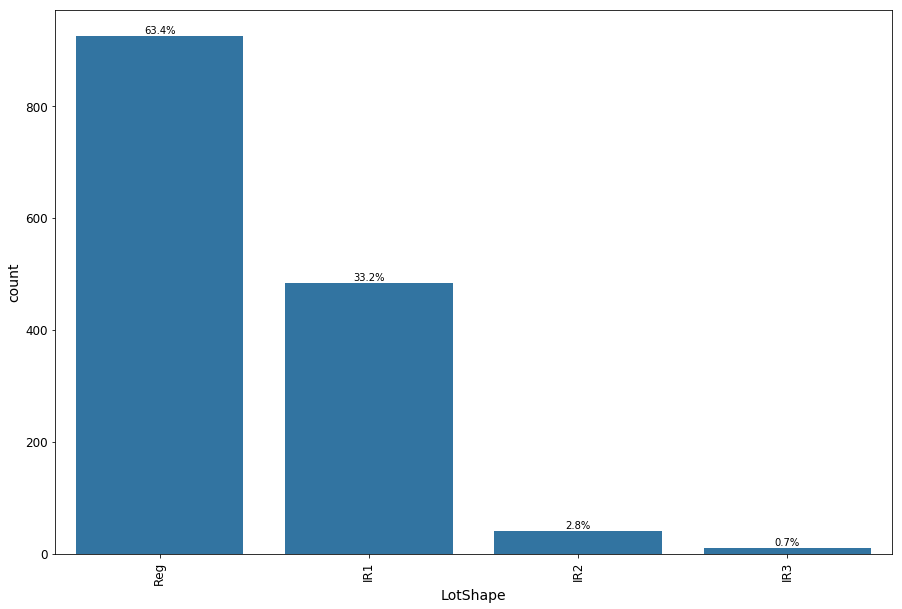

In [44]:
# Relative frequency variation - Plotting absolute counts on axis and porportions on the bars
# Barchart sorted by frequency
base_color = sns.color_palette()[0]
cat_order = train_eda[col_name].value_counts().index
plt.figure(figsize=(15,10))
plt.xticks(rotation = 90)
sns.countplot(data = train_eda, x = col_name, order = cat_order, color = base_color);

# add annotations
n_points = train_eda.shape[0]
cat_counts = train_eda[col_name].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)

    # print the annotation just below the top of the bar
    plt.text(loc, count+4, pct_string, ha = 'center', color = 'black')

##### Waffle Plot

(-0.8900000000000001, 9.89, 0.0, 10.780000000000001)

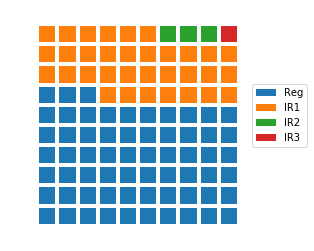

In [45]:
# There's no built-in function for waffle plots in Matplotlib or Seaborn, so we'll need to take some additional steps in order to build one with the tools available.
# The blocks are drawn from left to right, bottom to top
# First, we need to create a function to decide how many blocks to allocate to each category. The function below, percentage_blocks, uses a rule where each category gets a number of blocks equal to the number of full percentage points it covers. The remaining blocks to get to the full one hundred are assigned to the categories with the largest fractional parts.
def percentage_blocks(df, var):
    """
    Take as input a dataframe and variable, and return a Pandas series with
    approximate percentage values for filling out a waffle plot.
    """
    # compute base quotas
    percentages = 100 * df[var].value_counts() / df.shape[0]
    counts = np.floor(percentages).astype(int) # integer part = minimum quota
    decimal = (percentages - counts).sort_values(ascending = False)
    # add in additional counts to reach 100
    rem = 100 - counts.sum()
    for cat in decimal.index[:rem]:
        counts[cat] += 1
    return counts

# Second, plot those counts as boxes in the waffle plot form
waffle_counts = percentage_blocks(train_eda, col_name)
prev_count = 0
# for each category,
for cat in range(waffle_counts.shape[0]):
    # get the block indices
    blocks = np.arange(prev_count, prev_count + waffle_counts[cat])
    # and put a block at each index's location
    x = blocks % 10 # use mod operation to get ones digit
    y = blocks // 10 # use floor division to get tens digit
    plt.bar(x = x, height = 0.8, width = 0.8, bottom = y)
    prev_count += waffle_counts[cat]

# Third, we need to do involve aesthetic cleaning to polish it up for interpretability. We can take away the plot border and ticks, since they're arbitrary, but we should change the limits so that the boxes are square. We should also add a legend so that the mapping from colors to category levels is clear.
# aesthetic wrangling
plt.legend(waffle_counts.index, bbox_to_anchor = (1, 0.5), loc = 6)
plt.axis('off')
plt.axis('square')

##### Donut Plot

(-1.1156011989747219,
 1.1111671811030464,
 -1.1144471228780857,
 1.1123212571996826)

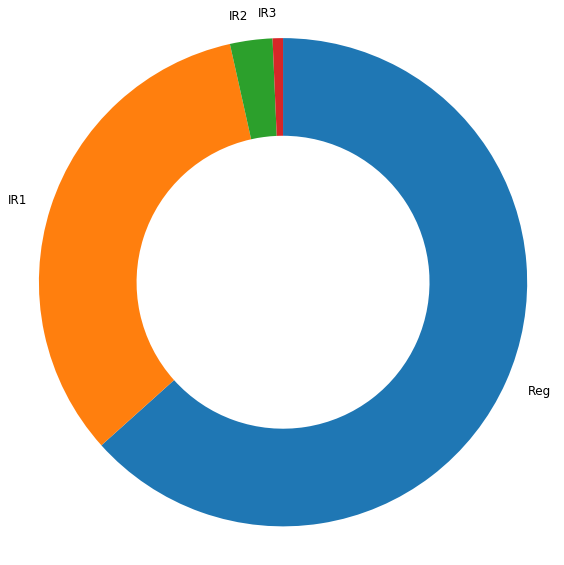

In [46]:
# Donut Chart
plt.figure(figsize=(15,10))
sorted_counts = train_eda[col_name].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90,
        counterclock = False, wedgeprops = {'width' : 0.4});
plt.axis('square')

##### Frequency Table for multiple variables

In [47]:
col_name = 'LotShape'
surv_s_class = pd.crosstab(index=train_eda["SaleType"], 
                             columns=[train_eda["GarageType"],
                                      train_eda["LotShape"]],
                             margins=True)
surv_s_class

GarageType 2Types Attchd              Basment     BuiltIn             CarPort  \
LotShape      Reg    IR1 IR2 IR3  Reg     IR1 Reg     IR1 IR2 IR3 Reg     IR1   
SaleType                                                                        
COD             0     10   0   0   15       2   2       0   0   0   0       0   
CWD             0      1   0   0    2       0   0       0   0   0   0       0   
Con             0      1   0   0    1       0   0       0   0   0   0       0   
ConLD           0      0   0   0    4       0   0       0   0   0   1       0   
ConLI           0      0   0   0    0       0   0       2   0   0   0       0   
ConLw           0      0   1   0    1       0   0       0   0   0   0       0   
New             0     36   3   1   56       0   1      10   1   1   7       0   
Oth             0      0   0   0    1       0   0       0   0   0   0       0   
WD              6    298  23   4  412       4  10      27   5   3  31       2   
All             6    346  27   5  492       6  13      39   6   4  39       2   

GarageType         Detchd                All  
LotShape   IR2 Reg    IR1 IR2 IR3  Reg        
SaleType                                      
COD          0   1      2   0   0   11    43  
CWD          0   0      0   0   0    1     4  
Con          0   0      0   0   0    0     2  
ConLD        0   0      0   0   0    2     7  
ConLI        0   0      0   0   0    2     4  
ConLw        0   0      1   0   0    1     4  
New          0   0      1   0   0    3   120  
Oth          0   0      0   0   0    0     1  
WD           1   5     70   7   1  285  1194  
All          1   6     74   7   1  305  1379

##### Stacked bar chart

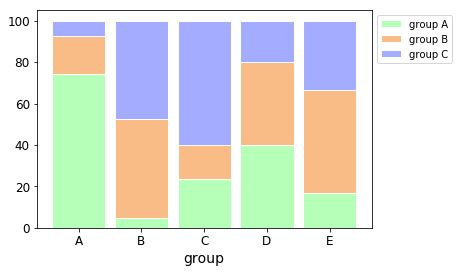

In [48]:
# Stacked plot
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
 
# Data
r = [0,1,2,3,4]
raw_data = {'greenBars': [20, 1.5, 7, 10, 5], 'orangeBars': [5, 15, 5, 10, 15],'blueBars': [2, 15, 18, 5, 10]}
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df['greenBars'], df['orangeBars'], df['blueBars'])]
greenBars = [i / j * 100 for i,j in zip(df['greenBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['orangeBars'], totals)]
blueBars = [i / j * 100 for i,j in zip(df['blueBars'], totals)]
 
# plot
barWidth = 0.85
names = ('A','B','C','D','E')
# Create green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth, label="group A")
# Create orange Bars
plt.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth, label="group B")
# Create blue Bars
plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='#a3acff', edgecolor='white', width=barWidth, label="group C")
 
# Custom x axis
plt.xticks(r, names)
plt.xlabel("group")
 
# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
 
# Show graphic
plt.show()

#### Numerical Variables

In [49]:
train_eda.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


##### Distribution

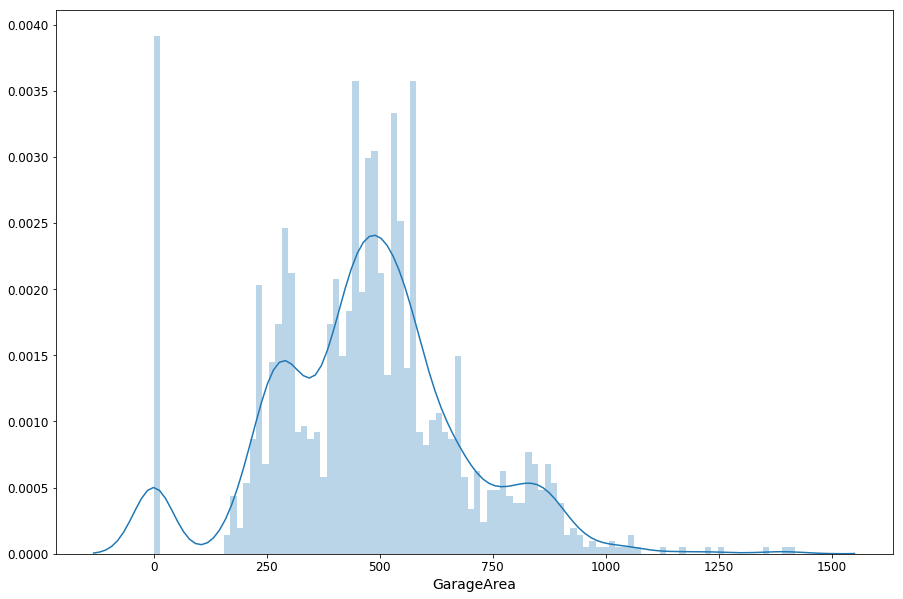

In [50]:
# Create a dist plot
col_name = 'GarageArea'
hist_kws={"alpha": 0.3}
plt.figure(figsize=(15,10))
# Trim long-tail/other values
# plt.xlim(0, 1200)
sns.distplot(train_eda[col_name], bins=100, hist_kws=hist_kws)

/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:340: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)


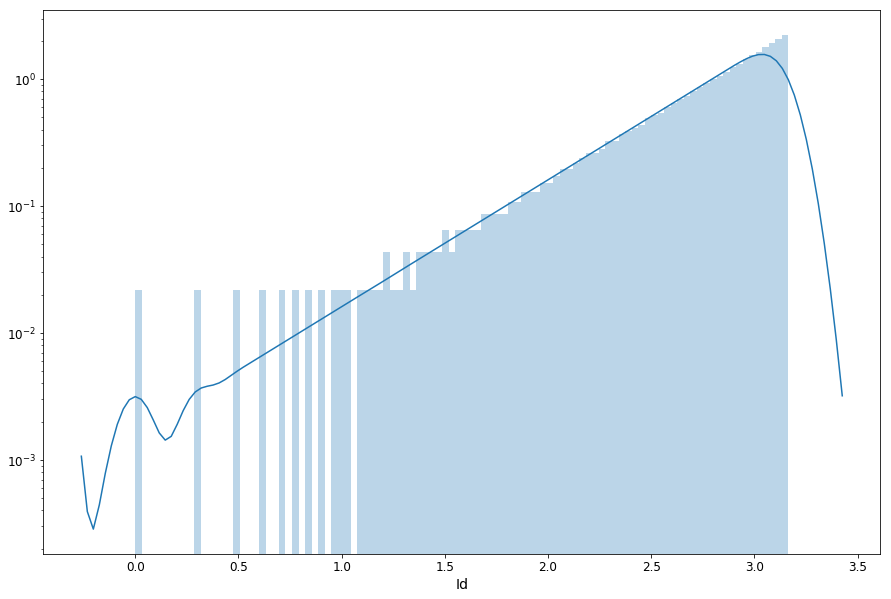

In [51]:
# Dist Plot in Log Scale
col_name = 'Id'
hist_kws={"alpha": 0.3, 'log':True}
plt.figure(figsize=(15,10))
sns.distplot(np.log10(train_eda[col_name]), bins=100, hist_kws=hist_kws);

In [52]:
# Optional: Trim long-tail/other values and create KDE again
ceiling_value = 500000
df_trimmed = df.loc[df.index[df.price < ceiling_value]].sample(n=50000)
sns.kdeplot(df_trimmed.col_name)
plt.show()

'\n# Optional: Trim long-tail/other values and create KDE again\nceiling_value = 500000\ndf_trimmed = df.loc[df.index[df.price < ceiling_value]].sample(n=50000)\nsns.kdeplot(df_trimmed.col_name)\nplt.show()\n'

##### Line Chart

In [ ]:
# libraries and data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame
df=pd.DataFrame({'x': range(1,11), 'y1': np.random.randn(10), 'y2': np.random.randn(10)+range(1,11), 'y3': np.random.randn(10)+range(11,21), 'y4': np.random.randn(10)+range(6,16), 'y5': np.random.randn(10)+range(4,14)+(0,0,0,0,0,0,0,-3,-8,-6), 'y6': np.random.randn(10)+range(2,12), 'y7': np.random.randn(10)+range(5,15), 'y8': np.random.randn(10)+range(4,14), 'y9': np.random.randn(10)+range(4,14), 'y10': np.random.randn(10)+range(2,12) })
 
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in df.drop('x', axis=1):
num+=1
plt.plot(df['x'], df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)
 
# Add legend
plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title("A (bad) Spaghetti plot", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Time")
plt.ylabel("Score")


##### Box and Whisker Plot

In [ ]:
base_color = sns.color_palette()[0]
sns.boxplot(data = train_eda, x = 'cat_var', y = 'num_var', color = base_color)

##### Violin Plot (Visualize the distribution of one numerical variable or lots of categorical variables)

In [ ]:
# Area depicts the distribution of points. > width = > the number of points
base_color = sns.color_palette()[0]
sns.violinplot(data = df, x = 'cat_var', y = 'num_var', color = base_color)
# switch x and y parameter values to make this a horizontal chart

##### Scatter Plot

[0, 400000, 0, 1200]

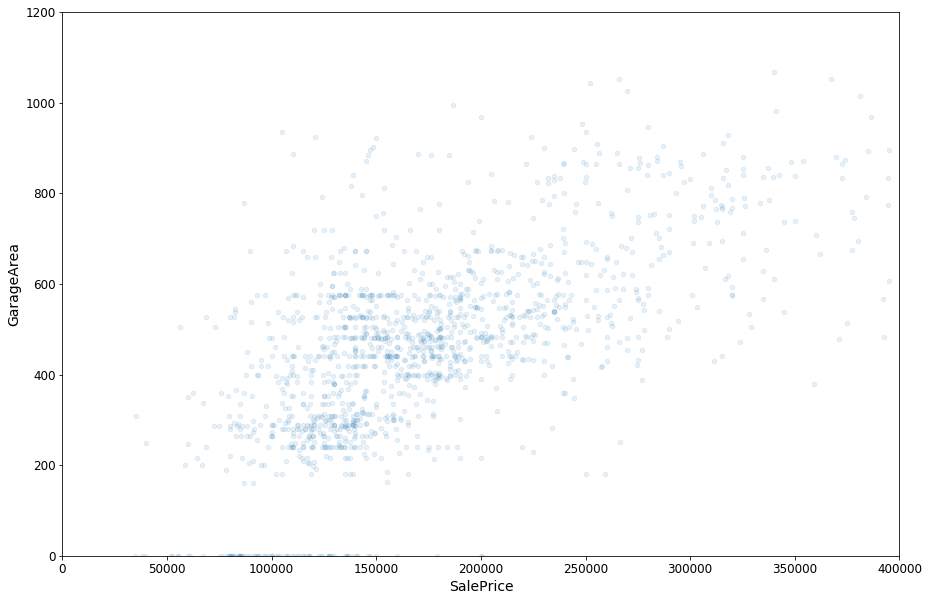

In [53]:
col_name = 'GarageArea'
train_eda.plot(kind="scatter", x=label_col, y=col_name, alpha=0.1, figsize=(15,10))
# changing axis labels to only show part of the graph
plt.axis([0, 400000, 0, 1200])

#### Multivariate Plots

##### Summary

| Univariate             | Graphical                               | Non-Graphical                     | 
|-------------|-----------------------------------------|-----------------------------------|
| Categorical | Bar char of frequencies (count / percent) | Frequency/Contingency table (count / percent) |
| Num/Continuous  | Histogram/rugplot/KDE, box/violin/swarm, qqplot, fat tails  | central tendency -mean/median/mode, spread - variance, std, skew, kurt, IQR  |

| Bivariate/multivariate            | Graphical                               | Non-Graphical                     | 
|-------------|-----------------------------------------|-----------------------------------|
| Categorical vs Categorical | heat map, mosaic plot | Two-way Contingency table (count/percent) |
| Continuous vs Continuous  | all pairwise scatterplots, kde, heatmaps |  all pairwise correlation/regression   |
| Categorical vs Continuous  | [bar, violin, swarm, point, strip seaborn plots](http://seaborn.pydata.org/tutorial/categorical.html)  | Summary statistics for each level |

##### Scatter Plot

In [ ]:
plt.scatter(data = df, x = 'num_var1', y = 'num_var2')
# adding a diagonal line through the chart values can help determine trends easily
# You can see if points are above or below the x=y relationship line, therefore if x is higher than y or vice versa
plt.plot([min_value,max_value], [min_value,max_value])

In [ ]:
# If we have a very large number of points to plot or our numeric variables are discrete-valued, then it is possible that using a scatterplot straightforwardly will not be informative. The visualization will suffer from overplotting, where the high amount of overlap in points makes it difficult to see the actual relationship between the plotted variables.
# In cases like this, we may want to employ transparency and jitter to make the scatterplot more informative.
# Add Transparency to deal with Overplotting
# Where more points overlap, the darker the image will be.
plt.scatter(data = df, x = 'disc_var1', y = 'disc_var2', alpha = 0.2)


In [ ]:
# With color and size
plt.scatter(x, y, s=scale, c=color, alpha=0.3, edgecolors='blue')

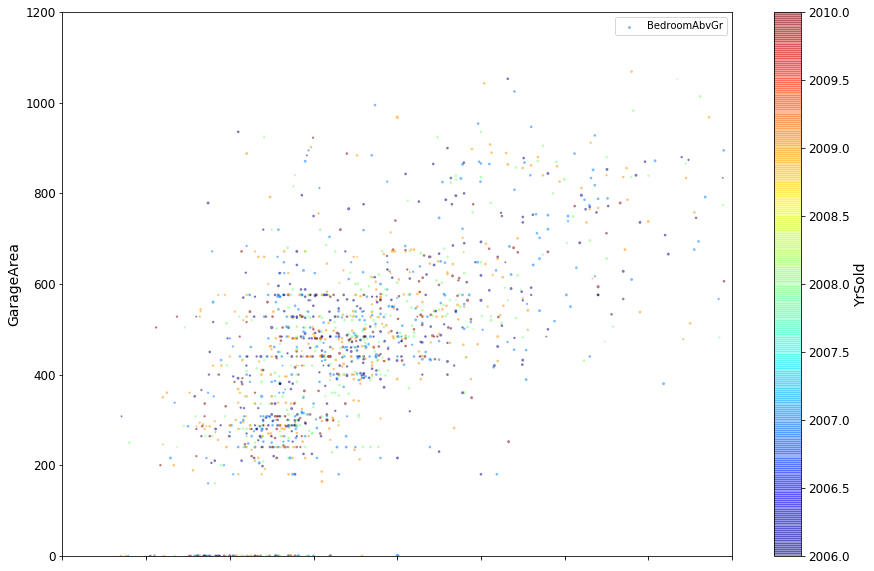

In [58]:
# With color and size
train_eda.plot(kind="scatter", x=label_col, y="GarageArea", alpha=0.4,
             s=train_eda["BedroomAbvGr"], label="BedroomAbvGr", figsize=(15,10),
             c="YrSold", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.axis([0, 400000, 0, 1200])
plt.legend()

##### Reg Plot

In [ ]:
# regplot combines scatterplot with regression function fitting
sns.regplot(data = df, x = 'num_var1', y = 'num_var2')

In [ ]:
# Add Jitter to deal with Overplotting
# adding jitter moves the position of each point slightly from its true value
# each point will be plotted in a uniform ±0.2 range of its true values
# jitter won't affect the fit of any regression function, if made
sns.regplot(data = df, x = 'disc_var1', y = 'disc_var2', fit_reg = False,
           x_jitter = 0.2, y_jitter = 0.2, scatter_kws = {'alpha' : 1/3})

##### Heat Map

In [ ]:
# Visual relationship between the color and density of data
# Add counts cause color perception is imprecise
# Prefer this over a scatterplot if we have 2 discrete variables since the jitter scatterplot can be imprecise. It's also better than adding transparency to a scatterplot in cases where there's a large amount of data.
# However, bin size does affect our interpretation of the data, so make sure to pick the right bin size
# darker values = higher value counts
# specify bin edges for the x and y axis
bins_x = np.arange(0.6, df['disc_var1'].max()+0.4, 0.4)
bins_y = np.arange(0, df['disc_var2'].max()+50, 50)
plt.hist2d(data = df, x = 'disc_var1', y = 'disc_var2',
           bins = [bins_x, bins_y], cmap = 'viridis_r', cmin = 0.5)
plt.colorbar()
plt.xlabel('Displacement (l)')
plt.ylabel('CO2 (g/mi)')

In [ ]:
# Heat Map with counts in each cell
# If you have too many cells in your heat map, then the annotations will end up being too overwhelming,
# too much to attend to. In cases like that, it's best to leave off the annotations and let the data
# and colorbar speak for themselves. You're more likely to see annotations in a categorical heat map,
# where there are going to be fewer cells plotted.
# hist2d returns a number of different variables, including an array of counts
bins_x = np.arange(0.6, df['disc_var1'].max()+0.4, 0.4)
bins_y = np.arange(0, df['disc_var2'].max()+50, 50)
h2d = plt.hist2d(data = df, x = 'disc_var1', y = 'disc_var2',
               bins = [bins_x, bins_y], cmap = 'viridis_r', cmin = 0.5)
counts = h2d[0]
plt.xlabel('Displacement (l)')
plt.ylabel('CO2 (g/mi)')

# loop through the cell counts and add text annotations for each
for i in range(counts.shape[0]):
    for j in range(counts.shape[1]):
        c = counts[i,j]
        if c >= 7: # increase visibility on darkest cells
            plt.text(bins_x[i]+0.5, bins_y[j]+0.5, int(c),
                     ha = 'center', va = 'center', color = 'white')
        elif c > 0:
            plt.text(bins_x[i]+0.5, bins_y[j]+0.5, int(c),
                     ha = 'center', va = 'center', color = 'black')

In [ ]:
# Heat Map (Categorical vs Categorical)
# Instead of providing the original dataframe, we need to summarize the counts into a matrix that will then be plotted.
ct_counts = df.groupby(['cat_var1', 'cat_var2']).size()
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot(index = 'cat_var2', columns = 'cat_var1', values = 'count')
sns.heatmap(ct_counts, annot = True, fmt = 'd')
# You can use fmt = '.0f' if you have any cells with no counts, in order to account for NaNs.

##### Violin Plot (Categorical vs Numeric)

In [ ]:
# Area depicts the distribution of points. > width = > the number of points
base_color = sns.color_palette()[0]
sns.violinplot(data = df, x = 'cat_var', y = 'num_var', color = base_color)
# switch x and y parameter values to make this a horizontal chart

##### Box Plot (Categorical vs Numeric)

In [ ]:
base_color = sns.color_palette()[0]
sns.boxplot(data = df, x = 'cat_var', y = 'num_var', color = base_color)
# switch x and y parameter values to make this a horizontal chart

##### Clustered Bar Charts (Categorical vs Categorical)

In [ ]:
sns.countplot(data = df, x = 'cat_var1', hue = 'cat_var2')

##### Faceting (Categorical vs Numeric)

In [ ]:
# Faceting histograms of the quantitative variable, against the qualitative subsets of data
# Facet by col='' parameter
bin_edges = np.arange(-3, df['num_var'].max()+1/3, 1/3)
g = sns.FacetGrid(data = df, col = 'cat_var', size = 2, col_wrap=3)
g.map(plt.hist, "num_var", bins = bin_edges)
g.set_titles('{col_name}')

##### Other Plots

In [ ]:
# compare the means of a feature by different categories of label_colname
df.groupby('label_colname')['afeature'].agg(['count','mean'])

In [ ]:
# plot these means by different categories of label_colname
df['afeature'].groupby(df.label_colname).mean().plot(kind='bar', color=['blue', 'green']) 

In [ ]:
# Scatter plot + print pearson correlation
sns.lmplot('price', 'deal_probability', hue='another_categorical_feature', data=df, fit_reg=True, size=10, aspect=2, scatter_kws={'s': 10, 'alpha':0.3})
plt.xlabel('Price')
plt.ylabel('Deal Probability')
plt.show()
print(f'Pearson correlation : {scipy.stats.pearsonr(df.price.values, df.deal_probability.values)}')

In [ ]:
# Scatter plot with Bokeh (good for large datasets)
from bokeh.charts import Scatter, output_file, show

# Construct the scatter plot
p = Scatter(iris, x='Petal_length', y='Petal_width', color="Class", title="Petal Length vs Petal Width",
            xlabel="Sepal Length", ylabel="Sepal Width")

# Output the file 
output_file('scatter.html')

# Show the scatter plot
show(p)

In [ ]:
# Violin plot -- to know if a categorical_var leans towards to a specific range of numerical_var
sns.violinplot('categorical_var', 'numerical_var', data=df)

# Optional: Trim long-tail/other values and create violin plot again
df_trimmed = df.loc[df.index[df.price < ceiling_value]].sample(n=50000)
sns.violinplot('categorical_var', 'numerical_var', data=df_trimmed)


In [ ]:
# Histograms of different values of categorical vars with numerical var in the same graph
hist_kws={"alpha": 0.2}
sns.distplot(df[df.categorical_var == 'Private']['numerical_var'], label='Private', hist_kws=hist_kws)
sns.distplot(df[df.categorical_var == 'Company']['numerical_var'], label='Company', hist_kws=hist_kws)
sns.distplot(df[df.categorical_var == 'Shop']['numerical_var'], label='Shop', hist_kws=hist_kws)
sns.distplot(df.numerical_var, label='All', hist_kws=hist_kws)
plt.title('numerical_var distribution')
plt.legend()
plt.show()

In [ ]:
# TODO: Add other combos of features to explore with labels

# Asking Questions and Hypothesis Building

An **independent variable (X)** is the variable that is changed or controlled in a scientific experiment to test the effects on the dependent variable.
A **dependent variable (Y)** is the variable being tested and measured in a scientific experiment.

D is the dependent variable
R is the responding variable
Y is the axis on which the dependent or responding variable is graphed (the vertical axis)

M is the manipulated variable or the one that is changed in an experiment
I is the independent variable
X is the axis on which the independent or manipulated variable is graphed (the horizontal axis)

**STEP 1:** Choose a data set that you would like to work with.

**STEP 2.** Identify a specific topic of interest

**STEP 3.** Prepare a codebook of your own (i.e., print individual pages or copy screen and paste into a new document) from the larger codebook that includes the questions/items/variables that measure your selected topics.)

**STEP 4.** Identify a second topic that you would like to explore in terms of its association with your original topic.

**STEP 5.** Add questions/items/variables documenting this second topic to your personal codebook.

**STEP 6.** Identify a basic research question that interests you. - "Is there an association between A and B
in subset of the population C"?

**STEP 7.** Once you have a basic research question, you can think about other variables that might explain your association.

**STEP 8.** Perform a literature review to see what research has been previously done on this topic. Use sites such as Google Scholar ([http://scholar.google.com](http://scholar.google.com/)) to search for published academic work in the area(s) of interest. Try to find multiple sources, and take note of basic bibliographic information.

**STEP 9.** Based on your literature review, develop a hypothesis about what you believe the association might be between these topics. Be sure to integrate the specific variables you selected into the hypothesis.

**STEP 10.** Ddscribe what you intend to do with your variables (data management/feature creation). For example, do I want to
look at how often adolescents binge drink, or do I want to create a binary variables (yes/no) for whether adolescents binge drank in the past month? Do I want depression to be a quantitative variable that aggregates multiple questions that ask about depression symptoms, or do I want to use a cutoff to create a categorical variable that groups adolescents into low, medium, or high levels of depression? These decisions should be described when you describe the variables you will be using.

All of this is a starting point for your analysis and will change as you perform the analysis.

**Get in the Mindset of a Detective**
- As an analyst, it is your job to extract information from data
- Go beyond the keyboard to investigate as if you are detective
- Have courage to ask the important questions
- You can also think of yourself as making a documentary about the data. - - You will ultimately tell some story about it. Make it accurate and interesting.

**2 Ways To Come Up With Questions**

1. You can go from looking at data -> coming up with questions -> finding a solution. Aas you look at data, form a list of questions.

2. Or, you can start with a question -> look at data to help solve it -> find a solution. As you look through data, figure out how you might solve a business problem.

# Prepare Data

In [ ]:
train_prep = train.copy()

# Split into features and labels
label = train_prep[label_col]
features = train_prep.drop(label_col, axis=1)

## Cleanup column names

In [67]:
def cleanup_column_names(df,rename_dict={},do_inplace=True):
    """This function renames columns of a pandas dataframe
       It converts column names to snake case if rename_dict is not passed. 
    Args:
        rename_dict (dict): keys represent old column names and values point to 
                            newer ones
        do_inplace (bool): flag to update existing dataframe or return a new one
    Returns:
        pandas dataframe if do_inplace is set to False, None otherwise

    """
    if not rename_dict:
        return df.rename(columns={col: col.lower().replace(' ','_') 
                    for col in df.columns.values.tolist()}, 
                  inplace=do_inplace)
    else:
        return df.rename(columns=rename_dict,inplace=do_inplace)

# Rename column names
cleanup_column_names(df)

## Sort rows on an attribute

In [ ]:
display(df.sort_values(['serial_no', 'price'], ascending=[True, False]).head())

## Rearrange column names

In [ ]:
display(df[['serial_no','date','user_id','user_type','product_id','quantity_purchased','price']].head())

## Filter Columns

Using Column Index

In [ ]:
# print 10 values from column at index 3
print(df.iloc[:,3].values[0:10])

Using Column Name

In [ ]:
# print 10 values from column at index 3
print(df.iloc[:,3].values[0:10])

Using Column Datatype

In [ ]:
# print 10 values of columns with data type float
print(df.select_dtypes(include=['float64']).values[:10,0])

## Filter Rows

Select specific rows

In [ ]:
display(df.iloc[[10,501,20]])

Exclude Specific Row indices

In [ ]:
display(df.drop([0,24,51], axis=0).head())

Conditional Filtering

In [ ]:
display(df[df.quantity_purchased>25].head())

Offset from top of the dataframe

In [ ]:
display(df[100:].head())

Offset from bottom of the dataframe

In [ ]:
display(df[-10:].head())

## TypeCasting: Data Type Conversion

In [ ]:
print(df.dtypes)
df['date'] = pd.to_datetime(df.date)
# compare dtypes of the original df with this one
print(df.dtypes)

## Create a derived attribute using map

In [ ]:
def derived_attribute(u_type):
    """This function maps user types to user classes
    Args:
        u_type (str): user type value
    Returns:
        (str) user_class value

    """
    if u_type in ['a','b']:
        return 'new_user'
    elif u_type == 'c':
        return 'existing'
    elif u_type == 'd':
        return 'loyal'
    else:
        return 'error'

In [ ]:
df['user_class'] = df['user_type'].map(expand_user_type)

## Create a binary derived attribute (a tag) using map and plot differences in the values of a categorical variable by tag value of a row

Example: we want to see if individuals who have 'FormalEducation'= one of ("Master's degree", "Doctoral", "Professional degree") weight different values of 'method' differently.

First we create a tag 'HigherEd' that is set to 1 if a row's FormalEducation categorical variable has any value in ("Master's degree", "Doctoral", "Professional degree").

In [ ]:
def higher_ed(formal_ed_str):
    '''
    INPUT
        formal_ed_str - a string of one of the values from the Formal Education column
    
    OUTPUT
        return 1 if the string is  in ("Master's degree", "Doctoral", "Professional degree")
        return 0 otherwise
    
    '''
    if formal_ed_str in ("Master's degree", "Doctoral", "Professional degree"):
        return 1
    else:
        return 0

# HigherEd is 1 or 0 depending on if FormalEducation has a value of ("Master's degree", "Doctoral", "Professional degree")
df['HigherEd'] = df["FormalEducation"].apply(higher_ed)
higher_ed_perc = df['HigherEd'].mean() # The percentage of individuals in these three groups


Second, we create 2 dataframes, 1 for each tag (HigherEd or !HigherEd)

In [ ]:
ed_1 = df[df['HigherEd']==1]
ed_0 = df[df['HigherEd']==0]

Third, we compute the column Diff_HigherEd_Vals == percentage of weight given by people with HigherEd tag 1 - HigherEd tag 2, to different method values.

We create a dataframe, and use https://pandas.pydata.org/pandas-docs/stable/style.html to map this difference visually onto the dataframe.
- The size of the bar suggests how much the variation is
- The color of the bars suggests which direction the variation is in


In [ ]:
#Check your subset is correct - you should get a plot that was created using pandas styling
#which you can learn more about here: https://pandas.pydata.org/pandas-docs/stable/style.html

ed_1_perc = clean_and_plot(ed_1, 'Higher Formal Education', plot=False)
ed_0_perc = clean_and_plot(ed_0, 'Max of Bachelors Higher Ed', plot=False)

comp_df = pd.merge(ed_1_perc, ed_0_perc, left_index=True, right_index=True)
comp_df.columns = ['ed_1_perc', 'ed_0_perc']
comp_df['Diff_HigherEd_Vals'] = comp_df['ed_1_perc'] - comp_df['ed_0_perc']
comp_df.style.bar(subset=['Diff_HigherEd_Vals'], align='mid', color=['#d65f5f', '#5fba7d'])

This prints a dataframe like:
<img src = 'images/udacity/stackoverflow-crispdm2.png'>


From the above image, we can conclude:
- Regardless of formal education, online courses are the top suggested form of education
- Those with higher formal education suggest it more than those who do not have it 
- There is about a 2.5% difference between suggestions of the two groups for Masters degree


For context, the distribution of values of the method categorical variable is:
<img src = 'images/udacity/stackoverflow-crispdm1.png'>

## Apply a function to the dataframe

Map : Create a derived attribute using map

In [ ]:
df['user_class'] = df['user_type'].map(expand_user_type) # can replace this with any other function
display(df.tail())

Apply: Using apply to get attribute ranges

In [ ]:
display(df.select_dtypes(include=[np.number]).apply(lambda x: x.max()- x.min()))

Applymap: Extract week from date

In [ ]:
df['purchase_week'] = df[['date']].applymap(lambda dt:dt.week 
                                            if not pd.isnull(dt.week) 
                                            else 0)

## Fill missing values

### See missing values

In [ ]:
sample_incomplete_rows = features[features.isnull().any(axis=1)].head()
sample_incomplete_rows

In [ ]:
missing_values_count = features.isnull().sum().sort_values(ascending=False)
missing_values_count

### Fix missing values

#### Drop Rows with missing dates

In [ ]:
df_dropped = df.dropna(subset=['date'])
display(df_dropped.head())

#### Fill Missing user_type values with value from previous row (forward fill)

In [ ]:
df_dropped['user_type'].fillna(method='ffill',inplace=True)

#### Fill Missing user_type values with value from next row (backward fill)

In [ ]:
df_dropped['user_type'].fillna(method='bfill',inplace=True)

#### Get rid of the corresponding datapoints

In [ ]:
features.dropna(subset=["missing_feature"])

#### Get rid of the whole attribute

In [ ]:
features.drop("missing_feature", axis=1)

#### Fill Missing Price values with mean price

In [ ]:
df_dropped['price'].fillna(value=np.round(df.price.mean(),decimals=2),
                                inplace=True)

#### Set the values to some value (zero, the mean, the median, etc.)

In [ ]:
# save the median value that you have computed. You will need it later to replace missing values in the test set when you want to evaluate your system, and also once the system goes live to replace missing values in new data
median = features["missing_feature"].median()
features["missing_feature"].fillna(median, inplace=True)

#### Imputer

Use an Imputer to impute missing values instead of calculating it manually.

The imputer has simply computed the median of each attribute and stored the result in its statistics_ instance variable. Only the missing_feature attribute had missing values, but we cannot be sure that there won’t be any missing values in new data after the system goes live, so it is safer to apply the imputer to all the numerical attributes

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

# The median can only be computed on numerical attributes, so we fetch the numerical attributes
features_num = features.select_dtypes(include=[np.number])

imputer.fit(features_num)

# Medians for each numerical feature
imputer.statistics_

# Fit to the training set
X = imputer.transform(features_num)

# The result is a plain NumPy array containing the transformed features. Convert it to a dataframe
features_num_tr = pd.DataFrame(X, columns=features_num.columns)

In [ ]:
# Check to see the result of Imputing
missing_values_count = features.isnull().sum().sort_values(ascending=False)
missing_values_count

features_num_tr_show = pd.DataFrame(X, columns=features_num.columns,
                          index = list(features.index.values))
features_num_tr_show.loc[sample_incomplete_rows.index.values]

## Duplicates

Drop Duplicate serial_no rows

In [27]:
# sample duplicates
display(df_dropped[df_dropped.duplicated(subset=['serial_no'])].head())
print("Shape of df={}".format(df_dropped.shape))

,date,price,product_id,quantity_purchased,serial_no,user_id,user_type,user_class,purchase_week
75,2016-07-02,4584.97,534,12,-1,5351,a,new,26
97,2016-01-01,743.37,965,3,-1,5264,c,existing,53
100,2016-07-01,3151.10,379,38,-1,5405,c,existing,26
114,2016-05-01,337.44,736,6,-1,5443,d,loyal_existing,17
145,2016-04-02,682.72,994,26,-1,5412,a,new,13


Shape of df=(969, 9)


In [28]:
df_dropped.drop_duplicates(subset=['serial_no'],inplace=True)

In [29]:
# updated dataframe
display(df_dropped.head())
print("Shape of df={}".format(df_dropped.shape))

,date,price,product_id,quantity_purchased,serial_no,user_id,user_type,user_class,purchase_week
0,2016-01-23,1395.65,0,3,1000,-101,n,error,3
4,2016-01-27,3850.22,929,3,1004,5489,n,error,4
5,2016-01-28,786.27,300,6,1005,5262,n,error,4
6,2016-01-22,2725.81,572,36,1006,5661,n,error,3
7,2016-10-01,4857.70,1011,14,1007,5412,n,error,39


Shape of df=(940, 9)


Remove rows which have less than 3 attributes with non-missing data

In [30]:
display(df.dropna(thresh=3).head())
print("Shape of df={}".format(df.dropna(thresh=3).shape))

,date,price,product_id,quantity_purchased,serial_no,user_id,user_type,user_class,purchase_week
0,2016-01-23,1395.65,0,3,1000,-101,n,error,3
1,NaT,1352.99,906,19,1001,5632,n,error,0
2,NaT,3997.32,625,21,1002,5240,n,error,0
3,NaT,3681.48,865,35,1003,5557,n,error,0
4,2016-01-27,3850.22,929,3,1004,5489,n,error,4


Shape of df=(1000, 9)


## Pivot Tables

In [44]:
display(df.pivot_table(index='date', columns='user_type', 
                         values='price',aggfunc=np.mean))

user_type,a,b,c,d,n
date,,,,,
2016-01-01,1764.427143,2783.268889,1372.035556,2394.892000,NaN
2016-01-02,2783.710000,1978.700000,2249.120000,2899.566667,NaN
2016-01-13,2693.746000,2589.390000,3011.610000,2391.913750,NaN
2016-01-14,2456.080000,1274.623333,2336.740000,2341.664286,NaN
2016-01-15,2784.635000,4452.075000,2389.252500,2019.024000,NaN
2016-01-16,1871.776667,4390.910000,1474.106000,3959.580000,NaN
2016-01-17,1838.467500,2715.795000,2396.167500,1604.277500,NaN
2016-01-18,2287.111667,4001.793750,2302.727500,2558.880000,4192.760000
2016-01-19,2666.602500,1599.908333,1752.883333,1199.605556,NaN


## Stack a Dataframe

In [45]:
print(df.stack())

0    date                  2016-01-23 00:00:00
     price                             1395.65
     product_id                              0
     quantity_purchased                      3
     serial_no                            1000
     user_id                              -101
     user_type                               n
     user_class                          error
     purchase_week                           3
1    price                             1352.99
     product_id                            906
     quantity_purchased                     19
     serial_no                            1001
     user_id                              5632
     user_type                               n
     user_class                          error
     purchase_week                           0
2    price                             3997.32
     product_id                            625
     quantity_purchased                     21
     serial_no                            1002
     user_id 

## Skewed features

In [ ]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

Box Cox Transformation of (highly) skewed features

We use the scipy function boxcox1p which computes the Box-Cox transformation of  1+x . Note that setting  λ=0  is equivalent to log1p. See [this page](http://onlinestatbook.com/2/transformations/box-cox.html) for more details on Box Cox Transformation as well as [the scipy function's page](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html)

In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

## Custom Transformer

the transformer has one hyperparameter, add_bedrooms_per_room, set to True by default (it is often helpful to provide sensible defaults). This hyperparameter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithms or not. More generally, you can add a hyperparameter to gate any data preparation step that you are not 100% sure about. The more you automate these data preparation steps, the more combinations you can automatically try out, making it much more likely that you will find a great combination (and saving you a lot of time).

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
train_extra_attribs = attr_adder.transform(train.values)

train_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(train.columns)+["rooms_per_household", "population_per_household"])
train_extra_attribs.head()

## Transformation Pipelines

The Pipeline constructor takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e., they must have a fit_transform() method). The names can be anything you like (as long as they are unique and don’t contain double underscores “__”): they will come in handy later for hyperparameter tuning.

When you call the pipeline’s fit() method, it calls fit_transform() sequentially on all transformers, passing the output of each call as the parameter to the next call, until it reaches the final estimator, for which it just calls the fit() method.

The pipeline exposes the same methods as the final estimator. In this example, the last estimator is a StandardScaler, which is a transformer, so the pipeline has a transform() method that applies all the transforms to the data in sequence (and of course also a fit_transform() method, which is the one we used).

Here is how this works: first we import the ColumnTransformer class, next we get the list of numerical column names and the list of categorical column names, and we construct a ColumnTransformer. The constructor requires a list of tuples, where each tuple contains a name22, a transformer and a list of names (or indices) of columns that the transformer should be applied to. In this example, we specify that the numerical columns should be transformed using the num_pipeline that we defined earlier, and the categorical columns should be transformed using a OneHotEncoder. Finally, we apply this ColumnTransformer to the housing data: it applies each transformer to the appropriate columns and concatenates the outputs along the second axis (the transformers must return the same number of rows).

Note that the OneHotEncoder returns a sparse matrix, while the num_pipeline returns a dense matrix. When there is such a mix of sparse and dense matrices, the ColumnTransformer estimates the density of the final matrix (i.e., the ratio of non-zero cells), and it returns a sparse matrix if the density is lower than a given threshold (by default, sparse_threshold=0.3). In this example, it returns a dense matrix. And that’s it! We have a preprocessing pipeline that takes the full housing data and applies the appropriate transformations to each column.

### Numerical Features

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

features_num_tr = num_pipeline.fit_transform(features_num)
features_num_tr

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(features_num)
cat_attribs = list(features_cat)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

# apply the full preprocessing pipeline to data
features_prepared = full_pipeline.fit_transform(features)
features_prepared[:5]

In [ ]:
features_prepared.shape

# Feature Engineering

## Overview

### By model type

**Linear Regression**

- Transform data for linear relationship (ex: log transform for exponential relationship)
- Remove noise such as outliers
- Rescale inputs using standardization or normalization

**Logistic Regression**

- Probability transformation to binary for classification
- Remove noise such as outliers

**Linear Discriminant Analysis**

- Review and modify univariate distributions to be Gaussian
- Standardize data to 𝜇 = 0, 𝜎 = 1 to have same variance
- Remove noise such as outliers

**Decision Trees**

- Can take any type of variables without modifications, and do not require any data preparation
- Modular arithmetic calculations: e.g. converting a timestamp into day of the week, or time of day. If your model needs to know that something happens on the third Monday of every month, it will be nearly impossible to determine this from timestamps.
- On a similar vein, creating new features from the data you have available can drastically improve your predictive power. This is where domain knowledge is extremely important - if you know of, or think you know of a relationship then you can include variables that describe that relationship. This is because tree based methods can only create splits that are horizontal or vertical (i.e. orthogonal to your data).
- Dimension reduction is typically performed by either feature selection or feature transformation. Reducing the dimension through feature selection will likely not help much with the models you mention, but an algorithm may or may not benefit from feature transformation (for example principal component analysis) depending on how much information is lost in the process. The only way to know for sure is to explore whether feature transformation provides better performance.

**Naive Bayes**

- Change numerical inputs to categorical (binning) or near-Gaussian inputs (remove outliers, log & boxcox transform)
- Other distributions can be used instead of Gaussian
- Log-transform of the probabilities can avoid overflow
- Probabilities can be updated as data becomes available

**KNN**

- Rescale inputs using standardization or normalization
- Address missing data for distance calculations
- Dimensionality reduction or feature selection for *COD*

**SVM**

- SVM assumes numeric inputs, may require dummy transformation of categorical features

**Bagging and RandomForest**

- None.
    - Based on DecisionTrees, so can take any type of variables without modifications, and do not require any data preparation.
    - Robust to overfitting and missing variables.

**Boosting and AdaBoost**

- Outliers should be removed for AdaBoost
    - Robust to overfitting and missing variables.
    - Based on DecisionTrees, so can take any type of variables without modifications, and do not require much data preparation.
- Modular arithmetic calculations: e.g. converting a timestamp into day of the week, or time of day. If your model needs to know that something happens on the third Monday of every month, it will be nearly impossible to determine this from timestamps.
- On a similar vein, creating new features from the data you have available can drastically improve your predictive power. This is where domain knowledge is extremely important - if you know of, or think you know of a relationship then you can include variables that describe that relationship. This is because tree based methods can only create splits that are horizontal or vertical (i.e. orthogonal to your data).
- Dimension reduction is typically performed by either feature selection or feature transformation. Reducing the dimension through feature selection will likely not help much with the models you mention, but an algorithm may or may not benefit from feature transformation (for example principal component analysis) depending on how much information is lost in the process. The only way to know for sure is to explore whether feature transformation provides better performance.
    
**XGBoost**

- Can take any type of variables without modifications, and do not require any data preparation
- Modular arithmetic calculations: e.g. converting a timestamp into day of the week, or time of day. If your model needs to know that something happens on the third Monday of every month, it will be nearly impossible to determine this from timestamps.
- On a similar vein, creating new features from the data you have available can drastically improve your predictive power. This is where domain knowledge is extremely important - if you know of, or think you know of a relationship then you can include variables that describe that relationship. This is because tree based methods can only create splits that are horizontal or vertical (i.e. orthogonal to your data).
- Dimension reduction is typically performed by either feature selection or feature transformation. Reducing the dimension through feature selection will likely not help much with the models you mention, but an algorithm may or may not benefit from feature transformation (for example principal component analysis) depending on how much information is lost in the process. The only way to know for sure is to explore whether feature transformation provides better performance.
- Feature Engineering:
    1. Feature selection
    2. Feature extraction
    3. Adding features through domain expertise
    
    
- XGBoost does (1) for you. XGBoost does not do (2)/(3) for you.
    - So you still have to do feature engineering yourself. Only a deep learning model could replace feature extraction for you.
    
    
- Feature selection: XGBoost does the feature selection up to a level. In my experience, I always do feature selection by a round of xgboost with parameters different than what I use for the final model. I typically use low numbers for row and feature sampling, and trees that are not deep and only keep the features that enter to the model. Then fine tune with another model. This prevented overfitting for me when the number of features was very high.


- Feature generation: XGBoost (classification, booster=gbtree) uses tree based methods. This means that the model would have hard time on picking relations such as **ab, a/b and a+b for features a and b. I usually add the interaction between features by hand or select the right ones with some heuristics.** Depending on the application, this can really boost the performance.

**Clustering**
- Missing value Handling
    - k-Means clustering just cannot deal with missing values. Any observation even with one missing dimension must be specially handled. If there are only few observations with missing values then these observations can be excluded from clustering. However, this must have equivalent rule during scoring about how to deal with missing values. Since in practice one cannot just refuse to exclude missing observations from segmentation, often better practice is to impute missing observations. There are various methods available for missing value imputation which can be a blog post in itself, but care must be taken to ensure that missing imputation doesn’t distort distance calculation implicit in k-Means algorithm. For example, replacing missing age with -1 or missing income with 999999 can be misleading!
- Categorical variables
    - k-Means uses distance computation at core of its algorithm, and hence cannot handle categorical variable directly. There are two ways this can be handled:
    - If categorical variables are ordinal variables*, then they can be replaced with arithmetic sequence of appropriate difference. Say, small/large can be replaced by 5/10. Because of unit normalization, difference doesn’t really matter.
    - If categorical variables are cardinal variables**, then they must be translated into as many binary numerical variables as number of categorical classes. Say, one cardinal variable with three classes (viz. car/bus/bike) can be converted into three binary variables.
- Data normalization
    - Distance computation in k-Means weights each dimension equally and hence care must be taken to ensure that unit of dimension shouldn’t distort relative near-ness of observations. Fig. 2 shows how relative distances can alter when units are changed for three 2-d observations. Common method is to unit-normalize each dimension individually. Even for simple dummy data from Fig. 1, clustering results may differ with and without unit normalization, as show in Fig. 3 below where one observation is classified differently.
    - keep in mind that outliers with equi-width binning can prevent k-Means from creating clusters that are different in content. The clusters may have very similar centroids, histograms, and rules.
    <img src="images/kmeans-feature-engineering.png" width=50%>
- Curse of dimensionality
    - As explained in previous blog post, any more than few tens of dimensions mean that distance interpretation isn’t obvious and must be guarded against. Appropriate dimensionality reduction techniques and distance measure must be used.
- Random initialization
    - k-Means clustering is prone to initial seeding i.e. random initialization of centroids which is required to kick-off iterative clustering process. Bad initialization may end up getting bad clusters. Fig. 4 shows one example where for  if initial seed happens to be one each in red, blue and green regions then we get true clustering (left image), but we may get wrong clustering (middle, right images) at other initial location.

### By data type

**Numeric Data**
- Scaling
- Ranking
- Quantization and Binning
- Box-Cox Transformation
- Yeo-Johnson Transformation
- Feature Interactions
- Clustering Features
- t-SNE Features
- PCA Features

**Categorical Data**
- One Hot Encoding
- Count Encoding
- Label Encoding
- Dummy Encoding
- Mean Encoding
- Hashing

**Textual Data**
- Bag of Words
- Phrase Detection Features
- TFIDF
- Word Embeddings
- Subword Embeddings
- Pattern Features
- Lexicon Features
- PoS Features

**Image Data**
- Computer Vision Algorithm Features
- Image Statistics Features
- OCR Features
- Deep Learning Features

**Time Series Data**
- Rolling Window Features
- Lag Features

**Geospatial Data**

## Categorical Data

- One Hot Encoding
- Count Encoding
- Label Encoding
- Dummy Encoding
- Mean Encoding
- Hashing

- [Understanding Feature Engineering (Part 2) -- Categorical Data](https://towardsdatascience.com/understanding-feature-engineering-part-2-categorical-data-f54324193e63)
-  One Hot Encoding
	- [Why One-Hot Encode Data in Machine Learning?](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)
	- [How to One Hot Encode Sequence Data in Python](https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/)
	- [sklearn.preprocessing.OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
	- [Keras - to_categorical](https://keras.io/utils/#to_categorical)
-  Count Encoding
	- [Feature engineering: Count encoding](https://www.slideshare.net/HJvanVeen/feature-engineering-72376750/11)
-  Label Encoding
	- [Label encoding in scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
	- [Feature engineering: Label encoding](https://www.slideshare.net/HJvanVeen/feature-engineering-72376750/9)
-  Dummy Encoding
	- [Dummy Coding: The how and why](http://www.statisticssolutions.com/dummy-coding-the-how-and-why/)
	- [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
	- [One-Hot vs Dummy encoding](https://stats.stackexchange.com/questions/224051/one-hot-vs-dummy-encoding-in-scikit-learn)
-  Mean Encoding
	- [Likelihood encoding of categorical features](https://www.kaggle.com/tnarik/likelihood-encoding-of-categorical-features)
	- [Python target encoding for categorical features](https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features)
	- [Adding variance column when mean encoding](https://www.kaggle.com/general/16927#95887)
-  Hashing
	- [Feature Hashing on Wikipedia](https://en.wikipedia.org/wiki/Feature_hashing)
	- [Feature hashing and Extraction in VowpalWabbit](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Feature-Hashing-and-Extraction)
	- [Feature hashing in scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html)

### Transforming Nominal Features - LabelEncoder

In [2]:
vg_df = pd.read_csv('datasets/vgsales.csv', encoding='utf-8')
vg_df[['Name', 'Platform', 'Year', 'Genre', 'Publisher']].iloc[1:7]

,Name,Platform,Year,Genre,Publisher
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo
5,Tetris,GB,1989.0,Puzzle,Nintendo
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo


In [3]:
genres = np.unique(vg_df['Genre'])
genres

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy'], dtype=object)

In [4]:
from sklearn.preprocessing import LabelEncoder

gle = LabelEncoder()
genre_labels = gle.fit_transform(vg_df['Genre'])
genre_mappings = {index: label for index, label in enumerate(gle.classes_)}
genre_mappings

{0: 'Action',
 1: 'Adventure',
 2: 'Fighting',
 3: 'Misc',
 4: 'Platform',
 5: 'Puzzle',
 6: 'Racing',
 7: 'Role-Playing',
 8: 'Shooter',
 9: 'Simulation',
 10: 'Sports',
 11: 'Strategy'}

In [5]:
vg_df['GenreLabel'] = genre_labels
vg_df[['Name', 'Platform', 'Year', 'Genre', 'GenreLabel']].iloc[1:7]

,Name,Platform,Year,Genre,GenreLabel
1,Super Mario Bros.,NES,1985.0,Platform,4
2,Mario Kart Wii,Wii,2008.0,Racing,6
3,Wii Sports Resort,Wii,2009.0,Sports,10
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,7
5,Tetris,GB,1989.0,Puzzle,5
6,New Super Mario Bros.,DS,2006.0,Platform,4


### Transforming Ordinal Features

In [6]:
poke_df = pd.read_csv('datasets/Pokemon.csv', encoding='utf-8')
poke_df = poke_df.sample(random_state=1, frac=1).reset_index(drop=True)

np.unique(poke_df['Generation'])

array(['Gen 1', 'Gen 2', 'Gen 3', 'Gen 4', 'Gen 5', 'Gen 6'], dtype=object)

In [7]:
gen_ord_map = {'Gen 1': 1, 'Gen 2': 2, 'Gen 3': 3, 
               'Gen 4': 4, 'Gen 5': 5, 'Gen 6': 6}

poke_df['GenerationLabel'] = poke_df['Generation'].map(gen_ord_map)
poke_df[['Name', 'Generation', 'GenerationLabel']].iloc[4:10]

,Name,Generation,GenerationLabel
4,Octillery,Gen 2,2
5,Helioptile,Gen 6,6
6,Dialga,Gen 4,4
7,DeoxysDefense Forme,Gen 3,3
8,Rapidash,Gen 1,1
9,Swanna,Gen 5,5


Label Mapping - Another way

In [32]:
type_map={'a':0,'b':1,'c':2,'d':3,np.NAN:-1}
df['encoded_user_type'] = df.user_type.map(type_map)
display((df.tail()))

,date,price,product_id,quantity_purchased,serial_no,user_id,user_type,user_class,purchase_week,encoded_user_type
995,2016-01-19,404.66,713,40,1995,5976,c,existing,3,2.0
996,2016-02-01,236.63,808,40,1996,5950,b,new,5,1.0
997,2016-08-01,3413.14,965,33,1997,5264,b,new,31,1.0
998,2016-10-02,4820.05,678,36,1998,5955,b,new,39,1.0
999,2016-01-15,3906.33,551,3,1999,5688,a,new,2,0.0


### Encoding Categorical Features

- if the categorical features are ordinal ones, use label encoder

- if non-ordinal relation, use one hot encoder

- if you are using LightGBM, you can use label encoder and set categorical_feature = [cat feature name]

#### One-hot Encoding

In [8]:
poke_df[['Name', 'Generation', 'Legendary']].iloc[4:10]

,Name,Generation,Legendary
4,Octillery,Gen 2,False
5,Helioptile,Gen 6,False
6,Dialga,Gen 4,True
7,DeoxysDefense Forme,Gen 3,True
8,Rapidash,Gen 1,False
9,Swanna,Gen 5,False


In [9]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# transform and map pokemon generations
gen_le = LabelEncoder()
gen_labels = gen_le.fit_transform(poke_df['Generation'])
poke_df['Gen_Label'] = gen_labels

# transform and map pokemon legendary status
leg_le = LabelEncoder()
leg_labels = leg_le.fit_transform(poke_df['Legendary'])
poke_df['Lgnd_Label'] = leg_labels

poke_df_sub = poke_df[['Name', 'Generation', 'Gen_Label', 'Legendary', 'Lgnd_Label']]
poke_df_sub.iloc[4:10]

,Name,Generation,Gen_Label,Legendary,Lgnd_Label
4,Octillery,Gen 2,1,False,0
5,Helioptile,Gen 6,5,False,0
6,Dialga,Gen 4,3,True,1
7,DeoxysDefense Forme,Gen 3,2,True,1
8,Rapidash,Gen 1,0,False,0
9,Swanna,Gen 5,4,False,0


In [10]:
# encode generation labels using one-hot encoding scheme
gen_ohe = OneHotEncoder()
gen_feature_arr = gen_ohe.fit_transform(poke_df[['Gen_Label']]).toarray()
gen_feature_labels = list(gen_le.classes_)
gen_features = pd.DataFrame(gen_feature_arr, columns=gen_feature_labels)

# encode legendary status labels using one-hot encoding scheme
leg_ohe = OneHotEncoder()
leg_feature_arr = leg_ohe.fit_transform(poke_df[['Lgnd_Label']]).toarray()
leg_feature_labels = ['Legendary_'+str(cls_label) for cls_label in leg_le.classes_]
leg_features = pd.DataFrame(leg_feature_arr, columns=leg_feature_labels)

In [11]:
poke_df_ohe = pd.concat([poke_df_sub, gen_features, leg_features], axis=1)
columns = sum([['Name', 'Generation', 'Gen_Label'],gen_feature_labels,
              ['Legendary', 'Lgnd_Label'],leg_feature_labels], [])
poke_df_ohe[columns].iloc[4:10]

,Name,Generation,Gen_Label,Gen 1,Gen 2,Gen 3,Gen 4,Gen 5,Gen 6,Legendary,Lgnd_Label,Legendary_False,Legendary_True
4,Octillery,Gen 2,1,0.0,1.0,0.0,0.0,0.0,0.0,False,0,1.0,0.0
5,Helioptile,Gen 6,5,0.0,0.0,0.0,0.0,0.0,1.0,False,0,1.0,0.0
6,Dialga,Gen 4,3,0.0,0.0,0.0,1.0,0.0,0.0,True,1,0.0,1.0
7,DeoxysDefense Forme,Gen 3,2,0.0,0.0,1.0,0.0,0.0,0.0,True,1,0.0,1.0
8,Rapidash,Gen 1,0,1.0,0.0,0.0,0.0,0.0,0.0,False,0,1.0,0.0
9,Swanna,Gen 5,4,0.0,0.0,0.0,0.0,1.0,0.0,False,0,1.0,0.0


In [12]:
new_poke_df = pd.DataFrame([['PikaZoom', 'Gen 3', True], 
                           ['CharMyToast', 'Gen 4', False]],
                           columns=['Name', 'Generation', 'Legendary'])
new_poke_df

,Name,Generation,Legendary
0,PikaZoom,Gen 3,True
1,CharMyToast,Gen 4,False


In [13]:
new_gen_labels = gen_le.transform(new_poke_df['Generation'])
new_poke_df['Gen_Label'] = new_gen_labels

new_leg_labels = leg_le.transform(new_poke_df['Legendary'])
new_poke_df['Lgnd_Label'] = new_leg_labels

new_poke_df[['Name', 'Generation', 'Gen_Label', 'Legendary', 'Lgnd_Label']]

,Name,Generation,Gen_Label,Legendary,Lgnd_Label
0,PikaZoom,Gen 3,2,True,1
1,CharMyToast,Gen 4,3,False,0


In [14]:
new_gen_feature_arr = gen_ohe.transform(new_poke_df[['Gen_Label']]).toarray()
new_gen_features = pd.DataFrame(new_gen_feature_arr, columns=gen_feature_labels)

new_leg_feature_arr = leg_ohe.transform(new_poke_df[['Lgnd_Label']]).toarray()
new_leg_features = pd.DataFrame(new_leg_feature_arr, columns=leg_feature_labels)

new_poke_ohe = pd.concat([new_poke_df, new_gen_features, new_leg_features], axis=1)
columns = sum([['Name', 'Generation', 'Gen_Label'], gen_feature_labels,
               ['Legendary', 'Lgnd_Label'], leg_feature_labels], [])
new_poke_ohe[columns]

,Name,Generation,Gen_Label,Gen 1,Gen 2,Gen 3,Gen 4,Gen 5,Gen 6,Legendary,Lgnd_Label,Legendary_False,Legendary_True
0,PikaZoom,Gen 3,2,0.0,0.0,1.0,0.0,0.0,0.0,True,1,0.0,1.0
1,CharMyToast,Gen 4,3,0.0,0.0,0.0,1.0,0.0,0.0,False,0,1.0,0.0


In [15]:
gen_onehot_features = pd.get_dummies(poke_df['Generation'])
pd.concat([poke_df[['Name', 'Generation']], gen_onehot_features], axis=1).iloc[4:10]

,Name,Generation,Gen 1,Gen 2,Gen 3,Gen 4,Gen 5,Gen 6
4,Octillery,Gen 2,0,1,0,0,0,0
5,Helioptile,Gen 6,0,0,0,0,0,1
6,Dialga,Gen 4,0,0,0,1,0,0
7,DeoxysDefense Forme,Gen 3,0,0,1,0,0,0
8,Rapidash,Gen 1,1,0,0,0,0,0
9,Swanna,Gen 5,0,0,0,0,1,0


One Hot Encoding - Another method

In [ ]:
features_cat = features.select_dtypes(exclude=[np.number])
features_cat.head(10)

In [ ]:
cat_encoder = OneHotEncoder(sparse=False)
features_cat_1hot = cat_encoder.fit_transform(features_cat)
features_cat_1hot # OHE returns a SciPy sparse matrix, instead of a NumPy array

One Hot Encoding using get_dummies()

In [31]:
display(pd.get_dummies(df,columns=['user_type']).head())

,date,price,product_id,quantity_purchased,serial_no,user_id,user_class,purchase_week,user_type_a,user_type_b,user_type_c,user_type_d,user_type_n
0,2016-01-23,1395.65,0,3,1000,-101,error,3,0,0,0,0,1
1,NaT,1352.99,906,19,1001,5632,error,0,0,0,0,0,1
2,NaT,3997.32,625,21,1002,5240,error,0,0,0,0,0,1
3,NaT,3681.48,865,35,1003,5557,error,0,0,0,0,0,1
4,2016-01-27,3850.22,929,3,1004,5489,error,4,0,0,0,0,1


#### Dummy Coding

In [16]:
gen_dummy_features = pd.get_dummies(poke_df['Generation'], drop_first=True)
pd.concat([poke_df[['Name', 'Generation']], gen_dummy_features], axis=1).iloc[4:10]

,Name,Generation,Gen 2,Gen 3,Gen 4,Gen 5,Gen 6
4,Octillery,Gen 2,1,0,0,0,0
5,Helioptile,Gen 6,0,0,0,0,1
6,Dialga,Gen 4,0,0,1,0,0
7,DeoxysDefense Forme,Gen 3,0,1,0,0,0
8,Rapidash,Gen 1,0,0,0,0,0
9,Swanna,Gen 5,0,0,0,1,0


In [17]:
gen_onehot_features = pd.get_dummies(poke_df['Generation'])
gen_dummy_features = gen_onehot_features.iloc[:,:-1]
pd.concat([poke_df[['Name', 'Generation']], gen_dummy_features], axis=1).iloc[4:10]

,Name,Generation,Gen 1,Gen 2,Gen 3,Gen 4,Gen 5
4,Octillery,Gen 2,0,1,0,0,0
5,Helioptile,Gen 6,0,0,0,0,0
6,Dialga,Gen 4,0,0,0,1,0
7,DeoxysDefense Forme,Gen 3,0,0,1,0,0
8,Rapidash,Gen 1,1,0,0,0,0
9,Swanna,Gen 5,0,0,0,0,1


#### Effect Coding

In [18]:
gen_onehot_features = pd.get_dummies(poke_df['Generation'])
gen_effect_features = gen_onehot_features.iloc[:,:-1]
gen_effect_features.loc[np.all(gen_effect_features == 0, axis=1)] = -1.
pd.concat([poke_df[['Name', 'Generation']], gen_effect_features], axis=1).iloc[4:10]

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Name,Generation,Gen 1,Gen 2,Gen 3,Gen 4,Gen 5
4,Octillery,Gen 2,0.0,1.0,0.0,0.0,0.0
5,Helioptile,Gen 6,-1.0,-1.0,-1.0,-1.0,-1.0
6,Dialga,Gen 4,0.0,0.0,0.0,1.0,0.0
7,DeoxysDefense Forme,Gen 3,0.0,0.0,1.0,0.0,0.0
8,Rapidash,Gen 1,1.0,0.0,0.0,0.0,0.0
9,Swanna,Gen 5,0.0,0.0,0.0,0.0,1.0


#### Feature Hashing

In [19]:
unique_genres = np.unique(vg_df[['Genre']])
print("Total game genres:", len(unique_genres))
print(unique_genres)

Total game genres: 12
['Action' 'Adventure' 'Fighting' 'Misc' 'Platform' 'Puzzle' 'Racing'
 'Role-Playing' 'Shooter' 'Simulation' 'Sports' 'Strategy']


In [20]:
from sklearn.feature_extraction import FeatureHasher

fh = FeatureHasher(n_features=6, input_type='string')
hashed_features = fh.fit_transform(vg_df['Genre'])
hashed_features = hashed_features.toarray()
pd.concat([vg_df[['Name', 'Genre']], pd.DataFrame(hashed_features)], axis=1).iloc[1:7]

,Name,Genre,0,1,2,3,4,5
1,Super Mario Bros.,Platform,0.0,2.0,2.0,-1.0,1.0,0.0
2,Mario Kart Wii,Racing,-1.0,0.0,0.0,0.0,0.0,-1.0
3,Wii Sports Resort,Sports,-2.0,2.0,0.0,-2.0,0.0,0.0
4,Pokemon Red/Pokemon Blue,Role-Playing,-1.0,1.0,2.0,0.0,1.0,-1.0
5,Tetris,Puzzle,0.0,1.0,1.0,-2.0,1.0,-1.0
6,New Super Mario Bros.,Platform,0.0,2.0,2.0,-1.0,1.0,0.0


In [21]:
fh.get_params()

{'dtype': numpy.float64,
 'input_type': 'string',
 'n_features': 6,
 'non_negative': False}

## Numeric Data

- Scaling
- Ranking
- Quantization and Binning
- Box-Cox Transformation
- Yeo-Johnson Transformation
- Feature Interactions
- Clustering Features
- t-SNE Features
- PCA Features

- [Understanding Feature Engineering (Part 1) -- Continuous Numeric Data](https://towardsdatascience.com/understanding-feature-engineering-part-1-continuous-numeric-data-da4e47099a7b)
-  Scaling
	- [sklearn.preprocessing.MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
	- [sklearn.preprocessing.StandartScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
-  Ranking
	- [Ranking](https://en.wikipedia.org/wiki/Ranking)
	- [scipy.stats.rankdata](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.rankdata.html)
-  Quantization and Binning
	- [Data Binning](https://en.wikipedia.org/wiki/Data_binning)
	- [Bucketing Continuous Variables in pandas](http://benalexkeen.com/bucketing-continuous-variables-in-pandas/)
	- [pandas.cat](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html)
-  Box-Cox Transformation
	- [scipy.stats.boxcox](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html)
	- `np.log (x + const)`
-  Yeo-Johnson Transformation
	- [Yeo-Johnson Transformation](https://gist.github.com/mesgarpour/f24769cd186e2db853957b10ff6b7a95)
-  Feature Interactions
	- [Featuretools](https://docs.featuretools.com/)
	- [sklearn.preprocessing.PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
	- Divisions
	- Other interactions
-  Clustering Features
	- [How to create New Features using Clustering!!](https://towardsdatascience.com/how-to-create-new-features-using-clustering-4ae772387290)
-  t-SNE Features
	- [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)
	- [Automatic feature extraction with t-SNE](https://medium.com/jungle-book/automatic-feature-extraction-with-t-sne-62826ce09268)
-  PCA Features
	- [Principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis)
	- [sklearn.decomposition.PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

### Scaling - Normalizing Numeric Values

#### Standard Scaler $\frac{x_i - \mu}{\sigma}$

In [ ]:
ss = StandardScaler()
df['zscore'] = ss.fit_transform(df[['col_name']])
df

In [ ]:
# Manually
vw = np.array(df['col_name'])
(vw[0] - np.mean(vw)) / np.std(vw)

#### Min-Max Scaler $\frac{x_i - min(x)}{max(x) - min(x)}$

In [ ]:
mms = MinMaxScaler()
df['minmax'] = mms.fit_transform(df[['col_name']])
df

In [ ]:
# Manually
(vw[0] - np.min(vw)) / (np.max(vw) - np.min(vw))

In [34]:
# Implementation with reshape
df_normalized = df.dropna().copy()
min_max_scaler = MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df_normalized['price'].values.reshape(-1,1))
df_normalized['price'] = np_scaled.reshape(-1,1)
display(df_normalized.head())

#### Robust Scaler $\frac{x_i - median(x)}{IQR_{(1,3)}(x)}$

In [ ]:
rs = RobustScaler()
df['robust'] = rs.fit_transform(df[['col_name']])
df

In [ ]:
# Manually
quartiles = np.percentile(vw, (25., 75.))
iqr = quartiles[1] - quartiles[0]
(vw[0] - np.median(vw)) / iqr

In [36]:
# Implementation with reshape
df_normalized = df.dropna().copy()
robust_scaler = RobustScaler()
rs_scaled = robust_scaler.fit_transform(df_normalized['quantity_purchased'].values.reshape(-1,1))
df_normalized['quantity_purchased'] = rs_scaled.reshape(-1,1)
display(df_normalized.head())

### Raw Measures

#### Values

In [2]:
poke_df = pd.read_csv('datasets/Pokemon.csv', encoding='utf-8')
poke_df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,Gen 1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,Gen 1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,Gen 1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,Gen 1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,Gen 1,False


In [3]:
poke_df[['HP', 'Attack', 'Defense']].head()

,HP,Attack,Defense
0,45,49,49
1,60,62,63
2,80,82,83
3,80,100,123
4,39,52,43


In [4]:
poke_df[['HP', 'Attack', 'Defense']].describe()

,HP,Attack,Defense
count,800.000000,800.000000,800.000000
mean,69.258750,79.001250,73.842500
std,25.534669,32.457366,31.183501
min,1.000000,5.000000,5.000000
25%,50.000000,55.000000,50.000000
50%,65.000000,75.000000,70.000000
75%,80.000000,100.000000,90.000000
max,255.000000,190.000000,230.000000


#### Counts

In [5]:
popsong_df = pd.read_csv('datasets/song_views.csv', encoding='utf-8')
popsong_df.head(10)

,user_id,song_id,title,listen_count
0,b6b799f34a204bd928ea014c243ddad6d0be4f8f,SOBONKR12A58A7A7E0,You're The One,2
1,b41ead730ac14f6b6717b9cf8859d5579f3f8d4d,SOBONKR12A58A7A7E0,You're The One,0
2,4c84359a164b161496d05282707cecbd50adbfc4,SOBONKR12A58A7A7E0,You're The One,0
3,779b5908593756abb6ff7586177c966022668b06,SOBONKR12A58A7A7E0,You're The One,0
4,dd88ea94f605a63d9fc37a214127e3f00e85e42d,SOBONKR12A58A7A7E0,You're The One,0
5,68f0359a2f1cedb0d15c98d88017281db79f9bc6,SOBONKR12A58A7A7E0,You're The One,0
6,116a4c95d63623a967edf2f3456c90ebbf964e6f,SOBONKR12A58A7A7E0,You're The One,17
7,45544491ccfcdc0b0803c34f201a6287ed4e30f8,SOBONKR12A58A7A7E0,You're The One,0
8,e701a24d9b6c59f5ac37ab28462ca82470e27cfb,SOBONKR12A58A7A7E0,You're The One,68
9,edc8b7b1fd592a3b69c3d823a742e1a064abec95,SOBONKR12A58A7A7E0,You're The One,0


### Binarization

In [6]:
watched = np.array(popsong_df['listen_count']) 
watched[watched >= 1] = 1
popsong_df['watched'] = watched
popsong_df.head(10)

,user_id,song_id,title,listen_count,watched
0,b6b799f34a204bd928ea014c243ddad6d0be4f8f,SOBONKR12A58A7A7E0,You're The One,2,1
1,b41ead730ac14f6b6717b9cf8859d5579f3f8d4d,SOBONKR12A58A7A7E0,You're The One,0,0
2,4c84359a164b161496d05282707cecbd50adbfc4,SOBONKR12A58A7A7E0,You're The One,0,0
3,779b5908593756abb6ff7586177c966022668b06,SOBONKR12A58A7A7E0,You're The One,0,0
4,dd88ea94f605a63d9fc37a214127e3f00e85e42d,SOBONKR12A58A7A7E0,You're The One,0,0
5,68f0359a2f1cedb0d15c98d88017281db79f9bc6,SOBONKR12A58A7A7E0,You're The One,0,0
6,116a4c95d63623a967edf2f3456c90ebbf964e6f,SOBONKR12A58A7A7E0,You're The One,17,1
7,45544491ccfcdc0b0803c34f201a6287ed4e30f8,SOBONKR12A58A7A7E0,You're The One,0,0
8,e701a24d9b6c59f5ac37ab28462ca82470e27cfb,SOBONKR12A58A7A7E0,You're The One,68,1
9,edc8b7b1fd592a3b69c3d823a742e1a064abec95,SOBONKR12A58A7A7E0,You're The One,0,0


In [7]:
from sklearn.preprocessing import Binarizer

bn = Binarizer(threshold=0.9)
pd_watched = bn.transform([popsong_df['listen_count']])[0]
popsong_df['pd_watched'] = pd_watched
popsong_df.head(11)

,user_id,song_id,title,listen_count,watched,pd_watched
0,b6b799f34a204bd928ea014c243ddad6d0be4f8f,SOBONKR12A58A7A7E0,You're The One,2,1,1
1,b41ead730ac14f6b6717b9cf8859d5579f3f8d4d,SOBONKR12A58A7A7E0,You're The One,0,0,0
2,4c84359a164b161496d05282707cecbd50adbfc4,SOBONKR12A58A7A7E0,You're The One,0,0,0
3,779b5908593756abb6ff7586177c966022668b06,SOBONKR12A58A7A7E0,You're The One,0,0,0
4,dd88ea94f605a63d9fc37a214127e3f00e85e42d,SOBONKR12A58A7A7E0,You're The One,0,0,0
5,68f0359a2f1cedb0d15c98d88017281db79f9bc6,SOBONKR12A58A7A7E0,You're The One,0,0,0
6,116a4c95d63623a967edf2f3456c90ebbf964e6f,SOBONKR12A58A7A7E0,You're The One,17,1,1
7,45544491ccfcdc0b0803c34f201a6287ed4e30f8,SOBONKR12A58A7A7E0,You're The One,0,0,0
8,e701a24d9b6c59f5ac37ab28462ca82470e27cfb,SOBONKR12A58A7A7E0,You're The One,68,1,1
9,edc8b7b1fd592a3b69c3d823a742e1a064abec95,SOBONKR12A58A7A7E0,You're The One,0,0,0


### Rounding

In [8]:
items_popularity = pd.read_csv('datasets/item_popularity.csv', encoding='utf-8')
items_popularity

,item_id,pop_percent
0,it_01345,0.98324
1,it_03431,0.56123
2,it_04572,0.12098
3,it_98021,0.35476
4,it_01298,0.92101
5,it_90120,0.81212
6,it_10123,0.56502


In [9]:
items_popularity['popularity_scale_10'] = np.array(np.round((items_popularity['pop_percent'] * 10)), dtype='int')
items_popularity['popularity_scale_100'] = np.array(np.round((items_popularity['pop_percent'] * 100)), dtype='int')
items_popularity

,item_id,pop_percent,popularity_scale_10,popularity_scale_100
0,it_01345,0.98324,10,98
1,it_03431,0.56123,6,56
2,it_04572,0.12098,1,12
3,it_98021,0.35476,4,35
4,it_01298,0.92101,9,92
5,it_90120,0.81212,8,81
6,it_10123,0.56502,6,57


### Interactions

In [10]:
atk_def = poke_df[['Attack', 'Defense']]
atk_def.head()

,Attack,Defense
0,49,49
1,62,63
2,82,83
3,100,123
4,52,43


In [11]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
res = pf.fit_transform(atk_def)
res

array([[    49.,     49.,   2401.,   2401.,   2401.],
       [    62.,     63.,   3844.,   3906.,   3969.],
       [    82.,     83.,   6724.,   6806.,   6889.],
       ..., 
       [   110.,     60.,  12100.,   6600.,   3600.],
       [   160.,     60.,  25600.,   9600.,   3600.],
       [   110.,    120.,  12100.,  13200.,  14400.]])

In [12]:
pd.DataFrame(pf.powers_, columns=['Attack_degree', 'Defense_degree'])

,Attack_degree,Defense_degree
0,1,0
1,0,1
2,2,0
3,1,1
4,0,2


In [13]:
intr_features = pd.DataFrame(res, columns=['Attack', 'Defense', 'Attack^2', 'Attack x Defense', 'Defense^2'])
intr_features.head(5)  

,Attack,Defense,Attack^2,Attack x Defense,Defense^2
0,49.0,49.0,2401.0,2401.0,2401.0
1,62.0,63.0,3844.0,3906.0,3969.0
2,82.0,83.0,6724.0,6806.0,6889.0
3,100.0,123.0,10000.0,12300.0,15129.0
4,52.0,43.0,2704.0,2236.0,1849.0


#### Transforming new data in the future (during predictions)

In [14]:
new_df = pd.DataFrame([[95, 75],[121, 120], [77, 60]], 
                      columns=['Attack', 'Defense'])
new_df

,Attack,Defense
0,95,75
1,121,120
2,77,60


In [15]:
new_res = pf.transform(new_df)
new_intr_features = pd.DataFrame(new_res, 
                                 columns=['Attack', 'Defense', 
                                          'Attack^2', 'Attack x Defense', 'Defense^2'])
new_intr_features

,Attack,Defense,Attack^2,Attack x Defense,Defense^2
0,95.0,75.0,9025.0,7125.0,5625.0
1,121.0,120.0,14641.0,14520.0,14400.0
2,77.0,60.0,5929.0,4620.0,3600.0


### Binning

In [16]:
fcc_survey_df = pd.read_csv('datasets/fcc_2016_coder_survey_subset.csv', encoding='utf-8')
fcc_survey_df[['ID.x', 'EmploymentField', 'Age', 'Income']].head()

,ID.x,EmploymentField,Age,Income
0,cef35615d61b202f1dc794ef2746df14,office and administrative support,28.0,32000.0
1,323e5a113644d18185c743c241407754,food and beverage,22.0,15000.0
2,b29a1027e5cd062e654a63764157461d,finance,19.0,48000.0
3,04a11e4bcb573a1261eb0d9948d32637,"arts, entertainment, sports, or media",26.0,43000.0
4,9368291c93d5d5f5c8cdb1a575e18bec,education,20.0,6000.0


#### Fixed-width binning

##### Developer age distribution

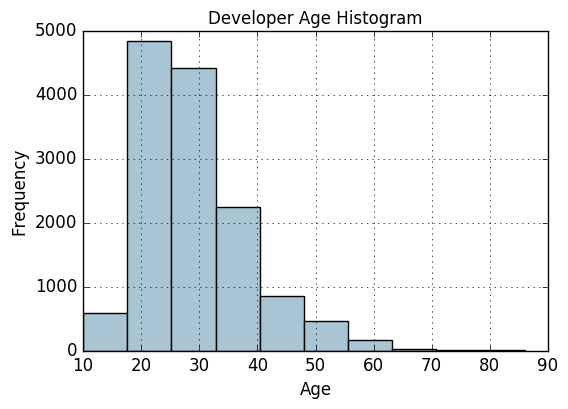

In [17]:
fig, ax = plt.subplots()
fcc_survey_df['Age'].hist(color='#A9C5D3')
ax.set_title('Developer Age Histogram', fontsize=12)
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

##### Binning based on rounding

``` 
Age Range: Bin
---------------
 0 -  9  : 0
10 - 19  : 1
20 - 29  : 2
30 - 39  : 3
40 - 49  : 4
50 - 59  : 5
60 - 69  : 6
  ... and so on
```

In [18]:
fcc_survey_df['Age_bin_round'] = np.array(np.floor(np.array(fcc_survey_df['Age']) / 10.))
fcc_survey_df[['ID.x', 'Age', 'Age_bin_round']].iloc[1071:1076]

,ID.x,Age,Age_bin_round
1071,6a02aa4618c99fdb3e24de522a099431,17.0,1.0
1072,f0e5e47278c5f248fe861c5f7214c07a,38.0,3.0
1073,6e14f6d0779b7e424fa3fdd9e4bd3bf9,21.0,2.0
1074,c2654c07dc929cdf3dad4d1aec4ffbb3,53.0,5.0
1075,f07449fc9339b2e57703ec7886232523,35.0,3.0


##### Binning based on custom ranges

``` 
Age Range : Bin
---------------
 0 -  15  : 1
16 -  30  : 2
31 -  45  : 3
46 -  60  : 4
61 -  75  : 5
75 - 100  : 6
```

In [19]:
bin_ranges = [0, 15, 30, 45, 60, 75, 100]
bin_names = [1, 2, 3, 4, 5, 6]
fcc_survey_df['Age_bin_custom_range'] = pd.cut(np.array(fcc_survey_df['Age']), 
                                               bins=bin_ranges)
fcc_survey_df['Age_bin_custom_label'] = pd.cut(np.array(fcc_survey_df['Age']), 
                                               bins=bin_ranges, labels=bin_names)
fcc_survey_df[['ID.x', 'Age', 'Age_bin_round', 
               'Age_bin_custom_range', 'Age_bin_custom_label']].iloc[1071:1076]

,ID.x,Age,Age_bin_round,Age_bin_custom_range,Age_bin_custom_label
1071,6a02aa4618c99fdb3e24de522a099431,17.0,1.0,"(15, 30]",2
1072,f0e5e47278c5f248fe861c5f7214c07a,38.0,3.0,"(30, 45]",3
1073,6e14f6d0779b7e424fa3fdd9e4bd3bf9,21.0,2.0,"(15, 30]",2
1074,c2654c07dc929cdf3dad4d1aec4ffbb3,53.0,5.0,"(45, 60]",4
1075,f07449fc9339b2e57703ec7886232523,35.0,3.0,"(30, 45]",3


#### Quantile based binning

In [20]:
fcc_survey_df[['ID.x', 'Age', 'Income']].iloc[4:9]

,ID.x,Age,Income
4,9368291c93d5d5f5c8cdb1a575e18bec,20.0,6000.0
5,dd0e77eab9270e4b67c19b0d6bbf621b,34.0,40000.0
6,7599c0aa0419b59fd11ffede98a3665d,23.0,32000.0
7,6dff182db452487f07a47596f314bddc,35.0,40000.0
8,9dc233f8ed1c6eb2432672ab4bb39249,33.0,80000.0


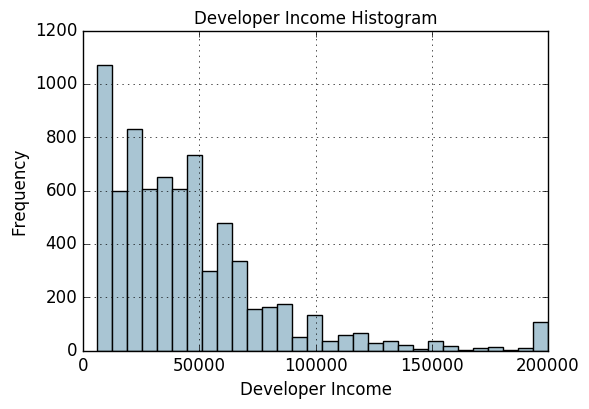

In [21]:
fig, ax = plt.subplots()
fcc_survey_df['Income'].hist(bins=30, color='#A9C5D3')
ax.set_title('Developer Income Histogram', fontsize=12)
ax.set_xlabel('Developer Income', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [22]:
quantile_list = [0, .25, .5, .75, 1.]
quantiles = fcc_survey_df['Income'].quantile(quantile_list)
quantiles

0.00      6000.0
0.25     20000.0
0.50     37000.0
0.75     60000.0
1.00    200000.0
Name: Income, dtype: float64

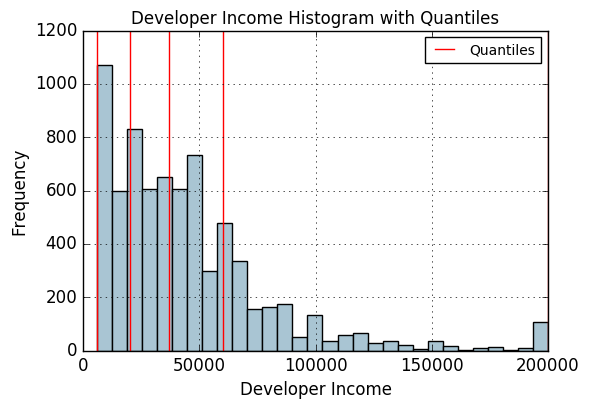

In [23]:
fig, ax = plt.subplots()
fcc_survey_df['Income'].hist(bins=30, color='#A9C5D3')

for quantile in quantiles:
    qvl = plt.axvline(quantile, color='r')
ax.legend([qvl], ['Quantiles'], fontsize=10)

ax.set_title('Developer Income Histogram with Quantiles', fontsize=12)
ax.set_xlabel('Developer Income', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [24]:
quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
fcc_survey_df['Income_quantile_range'] = pd.qcut(fcc_survey_df['Income'], 
                                                 q=quantile_list)
fcc_survey_df['Income_quantile_label'] = pd.qcut(fcc_survey_df['Income'], 
                                                 q=quantile_list, labels=quantile_labels)
fcc_survey_df[['ID.x', 'Age', 'Income', 
               'Income_quantile_range', 'Income_quantile_label']].iloc[4:9]

,ID.x,Age,Income,Income_quantile_range,Income_quantile_label
4,9368291c93d5d5f5c8cdb1a575e18bec,20.0,6000.0,"(5999.999, 20000.0]",0-25Q
5,dd0e77eab9270e4b67c19b0d6bbf621b,34.0,40000.0,"(37000.0, 60000.0]",50-75Q
6,7599c0aa0419b59fd11ffede98a3665d,23.0,32000.0,"(20000.0, 37000.0]",25-50Q
7,6dff182db452487f07a47596f314bddc,35.0,40000.0,"(37000.0, 60000.0]",50-75Q
8,9dc233f8ed1c6eb2432672ab4bb39249,33.0,80000.0,"(60000.0, 200000.0]",75-100Q


### Mathematical Transformations

#### Log transform

In [ ]:
# custom base
array = np.array([74088, 3111696])  # = [42**3, 42**4]
base = 42
exponent = np.log(array) / np.log(base)  # = [3, 4]

In [25]:
fcc_survey_df['Income_log'] = np.log((1 + fcc_survey_df['Income']))
fcc_survey_df[['ID.x', 'Age', 'Income', 'Income_log']].iloc[4:9]

,ID.x,Age,Income,Income_log
4,9368291c93d5d5f5c8cdb1a575e18bec,20.0,6000.0,8.699681
5,dd0e77eab9270e4b67c19b0d6bbf621b,34.0,40000.0,10.596660
6,7599c0aa0419b59fd11ffede98a3665d,23.0,32000.0,10.373522
7,6dff182db452487f07a47596f314bddc,35.0,40000.0,10.596660
8,9dc233f8ed1c6eb2432672ab4bb39249,33.0,80000.0,11.289794


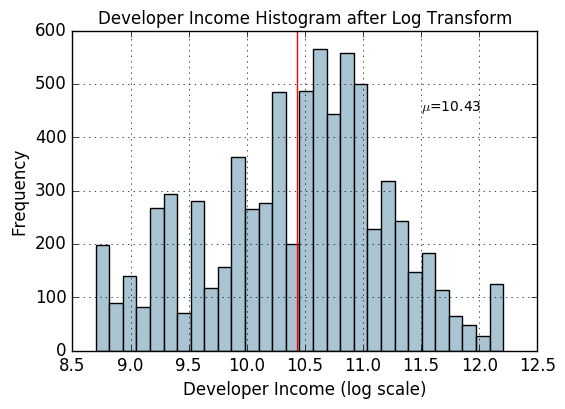

In [26]:
income_log_mean = np.round(np.mean(fcc_survey_df['Income_log']), 2)

fig, ax = plt.subplots()
fcc_survey_df['Income_log'].hist(bins=30, color='#A9C5D3')
plt.axvline(income_log_mean, color='r')
ax.set_title('Developer Income Histogram after Log Transform', fontsize=12)
ax.set_xlabel('Developer Income (log scale)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(11.5, 450, r'$\mu$='+str(income_log_mean), fontsize=10)

#### Box–Cox transform

In [27]:
# get optimal lambda value from non null income values
income = np.array(fcc_survey_df['Income'])
income_clean = income[~np.isnan(income)]
l, opt_lambda = spstats.boxcox(income_clean)
print('Optimal lambda value:', opt_lambda)

Optimal lambda value: 0.117991239456


In [28]:
fcc_survey_df['Income_boxcox_lambda_0'] = spstats.boxcox((1+fcc_survey_df['Income']), 
                                                         lmbda=0)
fcc_survey_df['Income_boxcox_lambda_opt'] = spstats.boxcox(fcc_survey_df['Income'], 
                                                           lmbda=opt_lambda)
fcc_survey_df[['ID.x', 'Age', 'Income', 'Income_log', 
               'Income_boxcox_lambda_0', 'Income_boxcox_lambda_opt']].iloc[4:9]

C:\Program Files\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1030: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


,ID.x,Age,Income,Income_log,Income_boxcox_lambda_0,Income_boxcox_lambda_opt
4,9368291c93d5d5f5c8cdb1a575e18bec,20.0,6000.0,8.699681,8.699681,15.180668
5,dd0e77eab9270e4b67c19b0d6bbf621b,34.0,40000.0,10.596660,10.596660,21.115342
6,7599c0aa0419b59fd11ffede98a3665d,23.0,32000.0,10.373522,10.373522,20.346420
7,6dff182db452487f07a47596f314bddc,35.0,40000.0,10.596660,10.596660,21.115342
8,9dc233f8ed1c6eb2432672ab4bb39249,33.0,80000.0,11.289794,11.289794,23.637131


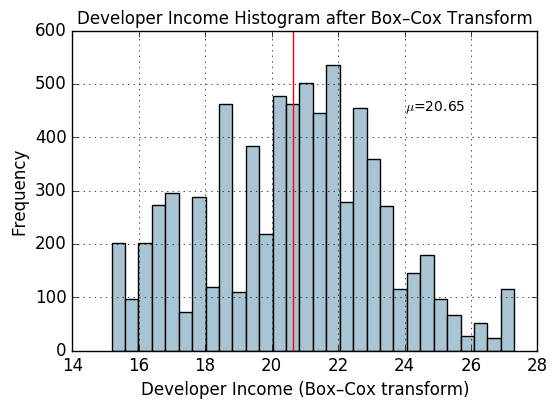

In [29]:
income_boxcox_mean = np.round(np.mean(fcc_survey_df['Income_boxcox_lambda_opt']), 2)

fig, ax = plt.subplots()
fcc_survey_df['Income_boxcox_lambda_opt'].hist(bins=30, color='#A9C5D3')
plt.axvline(income_boxcox_mean, color='r')
ax.set_title('Developer Income Histogram after Box–Cox Transform', fontsize=12)
ax.set_xlabel('Developer Income (Box–Cox transform)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(24, 450, r'$\mu$='+str(income_boxcox_mean), fontsize=10)

## Time Series Data

- Rolling Window Features
- Lag Features

- [Automatic extraction of relevant features from time series](http://tsfresh.readthedocs.io)
	- [Basic Feature Engineering With Time Series Data in Python](https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/)
-  Rolling Window Features
	- [pandas.DataFrame.rolling](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.rolling.html)
-  Lag Features
	- [Use pandas to lag your timeseries data in order to examine causal relationships](https://medium.com/@NatalieOlivo/use-pandas-to-lag-your-timeseries-data-in-order-to-examine-causal-relationships-f8186451b3a9)

### Import necessary dependencies and settings

In [1]:
from dateutil.parser import parse
import pytz

### Load and process sample temporal data

In [2]:
time_stamps = ['2015-03-08 10:30:00.360000+00:00', '2017-07-13 15:45:05.755000-07:00',
               '2012-01-20 22:30:00.254000+05:30', '2016-12-25 00:30:00.000000+10:00']
df = pd.DataFrame(time_stamps, columns=['Time'])
df

,Time
0,2015-03-08 10:30:00.360000+00:00
1,2017-07-13 15:45:05.755000-07:00
2,2012-01-20 22:30:00.254000+05:30
3,2016-12-25 00:30:00.000000+10:00


In [3]:
ts_objs = np.array([pd.Timestamp(item) for item in np.array(df.Time)])
df['TS_obj'] = ts_objs
ts_objs

array([Timestamp('2015-03-08 10:30:00.360000+0000', tz='UTC'),
       Timestamp('2017-07-13 15:45:05.755000-0700', tz='pytz.FixedOffset(-420)'),
       Timestamp('2012-01-20 22:30:00.254000+0530', tz='pytz.FixedOffset(330)'),
       Timestamp('2016-12-25 00:30:00+1000', tz='pytz.FixedOffset(600)')], dtype=object)

### Date based features

In [4]:
df['Year'] = df['TS_obj'].apply(lambda d: d.year)
df['Month'] = df['TS_obj'].apply(lambda d: d.month)
df['Day'] = df['TS_obj'].apply(lambda d: d.day)
df['DayOfWeek'] = df['TS_obj'].apply(lambda d: d.dayofweek)
df['DayName'] = df['TS_obj'].apply(lambda d: d.weekday_name)
df['DayOfYear'] = df['TS_obj'].apply(lambda d: d.dayofyear)
df['WeekOfYear'] = df['TS_obj'].apply(lambda d: d.weekofyear)
df['Quarter'] = df['TS_obj'].apply(lambda d: d.quarter)

df[['Time', 'Year', 'Month', 'Day', 'Quarter', 
    'DayOfWeek', 'DayName', 'DayOfYear', 'WeekOfYear']]

,Time,Year,Month,Day,Quarter,DayOfWeek,DayName,DayOfYear,WeekOfYear
0,2015-03-08 10:30:00.360000+00:00,2015,3,8,1,6,Sunday,67,10
1,2017-07-13 15:45:05.755000-07:00,2017,7,13,3,3,Thursday,194,28
2,2012-01-20 22:30:00.254000+05:30,2012,1,20,1,4,Friday,20,3
3,2016-12-25 00:30:00.000000+10:00,2016,12,25,4,6,Saturday,360,51


### Time based features

In [5]:
df['Hour'] = df['TS_obj'].apply(lambda d: d.hour)
df['Minute'] = df['TS_obj'].apply(lambda d: d.minute)
df['Second'] = df['TS_obj'].apply(lambda d: d.second)
df['MUsecond'] = df['TS_obj'].apply(lambda d: d.microsecond)
df['UTC_offset'] = df['TS_obj'].apply(lambda d: d.utcoffset())

df[['Time', 'Hour', 'Minute', 'Second', 'MUsecond', 'UTC_offset']]

,Time,Hour,Minute,Second,MUsecond,UTC_offset
0,2015-03-08 10:30:00.360000+00:00,10,30,0,360000,00:00:00
1,2017-07-13 15:45:05.755000-07:00,15,45,5,755000,-1 days +17:00:00
2,2012-01-20 22:30:00.254000+05:30,22,30,0,254000,05:30:00
3,2016-12-25 00:30:00.000000+10:00,0,30,0,0,10:00:00


In [6]:
hour_bins = [-1, 5, 11, 16, 21, 23]
bin_names = ['Late Night', 'Morning', 'Afternoon', 'Evening', 'Night']
df['TimeOfDayBin'] = pd.cut(df['Hour'], 
                            bins=hour_bins, labels=bin_names)
df[['Time', 'Hour', 'TimeOfDayBin']]

,Time,Hour,TimeOfDayBin
0,2015-03-08 10:30:00.360000+00:00,10,Morning
1,2017-07-13 15:45:05.755000-07:00,15,Afternoon
2,2012-01-20 22:30:00.254000+05:30,22,Night
3,2016-12-25 00:30:00.000000+10:00,0,Late Night


In [7]:
df['TZ_info'] = df['TS_obj'].apply(lambda d: d.tzinfo)
df['TimeZones'] = df['TS_obj'].apply(lambda d: list({d.astimezone(tz).tzname() 
                                   for tz in map(pytz.timezone, 
                                                 pytz.all_timezones_set)
                                       if d.astimezone(tz).utcoffset() == d.utcoffset()}))

df[['Time', 'UTC_offset', 'TZ_info', 'TimeZones']]

,Time,UTC_offset,TZ_info,TimeZones
0,2015-03-08 10:30:00.360000+00:00,00:00:00,UTC,"[WET, UTC, UCT, GMT]"
1,2017-07-13 15:45:05.755000-07:00,-1 days +17:00:00,pytz.FixedOffset(-420),"[MST, GMT+7, PDT]"
2,2012-01-20 22:30:00.254000+05:30,05:30:00,pytz.FixedOffset(330),[IST]
3,2016-12-25 00:30:00.000000+10:00,10:00:00,pytz.FixedOffset(600),"[VLAT, ChST, AEST, PGT, DDUT, GMT-10, CHUT]"


In [8]:
df['TimeUTC'] = df['TS_obj'].apply(lambda d: d.tz_convert(pytz.utc))
df['Epoch'] = df['TimeUTC'].apply(lambda d: d.timestamp())
df['GregOrdinal'] = df['TimeUTC'].apply(lambda d: d.toordinal())

df[['Time', 'TimeUTC', 'Epoch', 'GregOrdinal']]

,Time,TimeUTC,Epoch,GregOrdinal
0,2015-03-08 10:30:00.360000+00:00,2015-03-08 10:30:00.360000+00:00,1.425811e+09,735665
1,2017-07-13 15:45:05.755000-07:00,2017-07-13 22:45:05.755000+00:00,1.499986e+09,736523
2,2012-01-20 22:30:00.254000+05:30,2012-01-20 17:00:00.254000+00:00,1.327079e+09,734522
3,2016-12-25 00:30:00.000000+10:00,2016-12-24 14:30:00+00:00,1.482590e+09,736322


In [9]:
curr_ts = datetime.datetime.now(pytz.utc)
# compute days elapsed since today
df['DaysElapsedEpoch'] = (curr_ts.timestamp() - df['Epoch']) / (3600*24)
df['DaysElapsedOrdinal'] = (curr_ts.toordinal() - df['GregOrdinal']) 

df[['Time', 'TimeUTC', 'DaysElapsedEpoch', 'DaysElapsedOrdinal']]

,Time,TimeUTC,DaysElapsedEpoch,DaysElapsedOrdinal
0,2015-03-08 10:30:00.360000+00:00,2015-03-08 10:30:00.360000+00:00,860.207396,860
1,2017-07-13 15:45:05.755000-07:00,2017-07-13 22:45:05.755000+00:00,1.696917,2
2,2012-01-20 22:30:00.254000+05:30,2012-01-20 17:00:00.254000+00:00,2002.936564,2003
3,2016-12-25 00:30:00.000000+10:00,2016-12-24 14:30:00+00:00,203.040734,203


## Textual Data

- Bag of Words
- Phrase Detection Features
- TFIDF
- Word Embeddings
- Subword Embeddings
- Pattern Features
- Lexicon Features
- PoS Features

- [Understanding Feature Engineering (Part 3) -- Traditional Methods for Text Data](https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41)
-  Bag of Words
	- [Bag-of-words model](https://en.wikipedia.org/wiki/Bag-of-words_model)
	- [A Gentle Introduction to the Bag-of-Words Model](https://machinelearningmastery.com/gentle-introduction-bag-words-model/)
	- [sklearn.feature_extraction.text.CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
	- [sklearn.feature_extraction.DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html)
	- [sklearn.feature_extraction.FeatureHasher](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html)
-  Phrase Detection Features
	- [sklearn_api.phrases – Scikit learn wrapper for phrase (collocation) detection](https://radimrehurek.com/gensim/models/phrases.html)
-  TFIDF
	- [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
	- [sklearn.feature_extraction.text.TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
-  Word Embeddings
	- [Word embedding](https://en.wikipedia.org/wiki/Word_embedding)
	- [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/)
	- [Gensim: models.word2vec – Word2vec embeddings](https://radimrehurek.com/gensim/models/word2vec.html)
	- [fastText](https://fasttext.cc/)
	- [Word2Vec and FastText Word Embedding with Gensim](https://towardsdatascience.com/word-embedding-with-word2vec-and-fasttext-a209c1d3e12c)
	- [Do Pretrained Embeddings Give You The Extra Edge?](https://www.kaggle.com/sbongo/do-pretrained-embeddings-give-you-the-extra-edge)
-  Subword Embeddings
	- [Pre-trained subword embeddings in 275 languages, based on Byte-Pair Encoding (BPE)](https://github.com/bheinzerling/bpemb)
-  Pattern Features
	- [ClearTK - Feature Extraction Tutorial](https://cleartk.github.io/cleartk/docs/tutorial/feature_extraction.html)
	- Regular Expressions
-  Lexicon Features
	- [Named Entity Recognition with Bidirectional LSTM-CNNs (arXiv:1511.08308)](https://arxiv.org/abs/1511.08308v4)
-  PoS Features
	- [Part-of-Speech_Tagging](https://en.wikipedia.org/wiki/Part-of-speech_tagging)
	- [NLTK Categorizing and Tagging Words](https://www.nltk.org/book/ch05.html)
	- [How to use PoS features in scikit learn classfiers](https://stackoverflow.com/questions/24002485/python-how-to-use-pos-part-of-speech-features-in-scikit-learn-classfiers-svm)

### Sample corpus of text documents

In [2]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'animals', 'weather', 'animals']
corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,The brown fox is quick and the blue dog is lazy!,animals
4,The sky is very blue and the sky is very beaut...,weather
5,The dog is lazy but the brown fox is quick!,animals


### Simple text pre-processing

In [3]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [4]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog', 'brown fox quick blue dog lazy',
       'sky blue sky beautiful today', 'dog lazy brown fox quick'],
      dtype='<U30')

### Bag of Words Model

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0],
       [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1],
       [0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0]], dtype=int64)

In [6]:
vocab = cv.get_feature_names()
pd.DataFrame(cv_matrix, columns=vocab)

,beautiful,blue,brown,dog,fox,jumps,lazy,love,quick,sky,today
0,1,1,0,0,0,0,0,0,0,1,0
1,1,1,0,0,0,0,0,1,0,1,0
2,0,0,1,1,1,1,1,0,1,0,0
3,0,1,1,1,1,0,1,0,1,0,0
4,1,1,0,0,0,0,0,0,0,2,1
5,0,0,1,1,1,0,1,0,1,0,0


### Bag of N-Grams Model

In [7]:
bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(norm_corpus)
bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab)

,beautiful sky,beautiful today,blue beautiful,blue dog,blue sky,brown fox,dog lazy,fox jumps,fox quick,jumps lazy,lazy brown,lazy dog,love blue,quick blue,quick brown,sky beautiful,sky blue
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0
3,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,0
4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
5,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0


### TF-IDF Model

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(norm_corpus)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

,beautiful,blue,brown,dog,fox,jumps,lazy,love,quick,sky,today
0,0.60,0.52,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.60,0.00
1,0.46,0.39,0.00,0.00,0.00,0.00,0.00,0.66,0.00,0.46,0.00
2,0.00,0.00,0.38,0.38,0.38,0.54,0.38,0.00,0.38,0.00,0.00
3,0.00,0.36,0.42,0.42,0.42,0.00,0.42,0.00,0.42,0.00,0.00
4,0.36,0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.72,0.52
5,0.00,0.00,0.45,0.45,0.45,0.00,0.45,0.00,0.45,0.00,0.00


### Document Similarity

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5
0,1.000000,0.753128,0.000000,0.185447,0.807539,0.000000
1,0.753128,1.000000,0.000000,0.139665,0.608181,0.000000
2,0.000000,0.000000,1.000000,0.784362,0.000000,0.839987
3,0.185447,0.139665,0.784362,1.000000,0.109653,0.933779
4,0.807539,0.608181,0.000000,0.109653,1.000000,0.000000
5,0.000000,0.000000,0.839987,0.933779,0.000000,1.000000


#### Clustering documents using similarity features

In [10]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2)
km.fit_transform(similarity_df)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,1
1,Love this blue and beautiful sky!,weather,1
2,The quick brown fox jumps over the lazy dog.,animals,0
3,The brown fox is quick and the blue dog is lazy!,animals,0
4,The sky is very blue and the sky is very beaut...,weather,1
5,The dog is lazy but the brown fox is quick!,animals,0


### Topic models

In [11]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_topics=2, max_iter=100, random_state=42)
dt_matrix = lda.fit_transform(tv_matrix)
features = pd.DataFrame(dt_matrix, columns=['T1', 'T2'])
features

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


,T1,T2
0,0.190615,0.809385
1,0.176860,0.823140
2,0.846148,0.153852
3,0.815229,0.184771
4,0.180563,0.819437
5,0.839140,0.160860


#### Show topics and their weights

In [12]:
tt_matrix = lda.components_
for topic_weights in tt_matrix:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.6]
    print(topic)
    print()


[('fox', 1.7265536238698524), ('quick', 1.7264910761871224), ('dog', 1.7264019823624879), ('brown', 1.7263774760262807), ('lazy', 1.7263567668213813), ('jumps', 1.0326450363521607), ('blue', 0.7770158513472083)]

[('sky', 2.263185143458752), ('beautiful', 1.9057084998062579), ('blue', 1.7954559705805626), ('love', 1.1476805311187976), ('today', 1.0064979209198706)]



#### Clustering documents using topic model features

In [13]:
km = KMeans(n_clusters=2)
km.fit_transform(features)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,0
1,Love this blue and beautiful sky!,weather,0
2,The quick brown fox jumps over the lazy dog.,animals,1
3,The brown fox is quick and the blue dog is lazy!,animals,1
4,The sky is very blue and the sky is very beaut...,weather,0
5,The dog is lazy but the brown fox is quick!,animals,1


### Word Embeddings

In [14]:
from gensim.models import word2vec

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count = min_word_count,
                          sample=sample)

C:\Program Files\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [15]:
w2v_model.wv['sky']

array([ 0.01000661, -0.02096199,  0.03674392, -0.03230235,  0.02149896,
       -0.01101904,  0.01973963,  0.00615971, -0.01040678, -0.00668737], dtype=float32)

In [16]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [17]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9
0,-0.010540,-0.015367,0.005373,-0.020741,0.030717,-0.022407,-0.001724,0.004722,0.026881,0.011909
1,-0.017797,-0.013693,-0.003599,-0.015436,0.022831,-0.017905,0.010470,0.001540,0.025658,0.016208
2,-0.020869,-0.018273,-0.019681,-0.004124,-0.010980,0.001654,-0.001310,0.003395,0.003760,0.010851
3,-0.017561,-0.017866,-0.016438,-0.007601,-0.005687,-0.008843,-0.002385,0.001444,0.005643,0.012638
4,0.002371,-0.006731,0.017480,-0.014220,0.022088,-0.014882,0.003067,0.002605,0.021167,0.006461
5,-0.018306,-0.012056,-0.015671,-0.011617,-0.011667,-0.005490,0.005404,-0.003512,-0.003198,0.013306


In [18]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,0
1,Love this blue and beautiful sky!,weather,0
2,The quick brown fox jumps over the lazy dog.,animals,1
3,The brown fox is quick and the blue dog is lazy!,animals,1
4,The sky is very blue and the sky is very beaut...,weather,0
5,The dog is lazy but the brown fox is quick!,animals,1


## Image Data

- Computer Vision Algorithm Features
- Image Statistics Features
- OCR Features
- Deep Learning Features

-  Computer Vision Algorithm Features
	- [Feature extraction and similar image search with OpenCV for newbies](https://medium.com/machine-learning-world/feature-extraction-and-similar-image-search-with-opencv-for-newbies-3c59796bf774)
	- [OpenCV -- Feature Detection and Description](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html)
	- [SimpleCV.Features package](http://simplecv.readthedocs.io/en/latest/SimpleCV.Features.html)
	- [Scikit-image feature module](http://scikit-image.org/docs/stable/api/skimage.feature.html)
-  Image Statistics Features
	- [ImageStat Module -- Pillow](http://pillow.readthedocs.io/en/3.1.x/reference/ImageStat.html)
-  OCR Features
	- [A Python wrapper for Google Tesseract](https://github.com/madmaze/pytesseract)
-  Deep Learning Features
	- [Keras pre-trained models feature extraction](https://keras.io/applications/)
	- [Using Keras’ Pre-trained Models for Feature Extraction in Image Clustering](https://medium.com/@franky07724_57962/using-keras-pre-trained-models-for-feature-extraction-in-image-clustering-a142c6cdf5b1)

### Image metadata features

 - Image create date & time
 - Image dimensions
 - Image compression format
 - Device Make & Model
 - Image resolution & aspect ratio
 - Image Artist
 - Flash, Aperture, Focal Length & Exposure

### Raw Image and channel pixel values

In [2]:
cat = io.imread('datasets/cat.png')
dog = io.imread('datasets/dog.png')
df = pd.DataFrame(['Cat', 'Dog'], columns=['Image'])


print(cat.shape, dog.shape)

(168, 300, 3) (168, 300, 3)


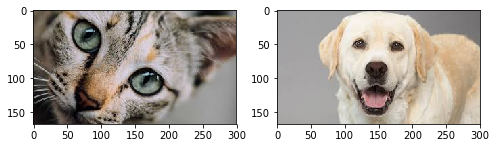

In [3]:
#coffee = skimage.transform.resize(coffee, (300, 451), mode='reflect')
fig = plt.figure(figsize = (8,4))
ax1 = fig.add_subplot(1,2, 1)
ax1.imshow(cat)
ax2 = fig.add_subplot(1,2, 2)
ax2.imshow(dog)

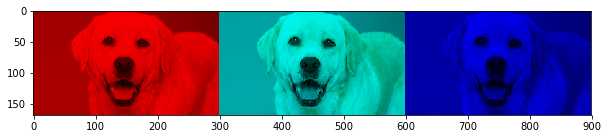

In [4]:
dog_r = dog.copy() # Red Channel
dog_r[:,:,1] = dog_r[:,:,2] = 0 # set G,B pixels = 0
dog_g = dog.copy() # Green Channel
dog_g[:,:,0] = dog_r[:,:,2] = 0 # set R,B pixels = 0
dog_b = dog.copy() # Blue Channel
dog_b[:,:,0] = dog_b[:,:,1] = 0 # set R,G pixels = 0

plot_image = np.concatenate((dog_r, dog_g, dog_b), axis=1)
plt.figure(figsize = (10,4))
plt.imshow(plot_image)

In [5]:
dog_r

array([[[160,   0,   0],
        [160,   0,   0],
        [160,   0,   0],
        ..., 
        [113,   0,   0],
        [113,   0,   0],
        [112,   0,   0]],

       [[160,   0,   0],
        [160,   0,   0],
        [160,   0,   0],
        ..., 
        [113,   0,   0],
        [113,   0,   0],
        [112,   0,   0]],

       [[160,   0,   0],
        [160,   0,   0],
        [160,   0,   0],
        ..., 
        [113,   0,   0],
        [113,   0,   0],
        [112,   0,   0]],

       ..., 
       [[165,   0,   0],
        [165,   0,   0],
        [165,   0,   0],
        ..., 
        [212,   0,   0],
        [211,   0,   0],
        [210,   0,   0]],

       [[165,   0,   0],
        [165,   0,   0],
        [165,   0,   0],
        ..., 
        [210,   0,   0],
        [210,   0,   0],
        [209,   0,   0]],

       [[164,   0,   0],
        [164,   0,   0],
        [164,   0,   0],
        ..., 
        [209,   0,   0],
        [209,   0,   0],
        [209,   0,

### Grayscale image pixel values

In [6]:
from skimage.color import rgb2gray

cgs = rgb2gray(cat)
dgs = rgb2gray(dog)

print('Image shape:', cgs.shape, '\n')

# 2D pixel map
print('2D image pixel map')
print(np.round(cgs, 2), '\n')

# flattened pixel feature vector
print('Flattened pixel map:', (np.round(cgs.flatten(), 2)))

Image shape: (168, 300) 

2D image pixel map
[[ 0.42  0.41  0.41 ...,  0.5   0.52  0.53]
 [ 0.41  0.41  0.4  ...,  0.51  0.52  0.54]
 [ 0.4   0.4   0.4  ...,  0.52  0.54  0.55]
 ..., 
 [ 0.11  0.11  0.1  ...,  0.51  0.51  0.51]
 [ 0.11  0.11  0.1  ...,  0.51  0.51  0.51]
 [ 0.11  0.11  0.1  ...,  0.51  0.51  0.51]] 

Flattened pixel map: [ 0.42  0.41  0.41 ...,  0.51  0.51  0.51]


### Binning image intensity distribution

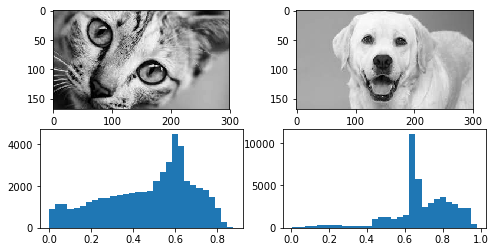

In [7]:
fig = plt.figure(figsize = (8,4))
ax1 = fig.add_subplot(2,2, 1)
ax1.imshow(cgs, cmap="gray")
ax2 = fig.add_subplot(2,2, 2)
ax2.imshow(dgs, cmap='gray')
ax3 = fig.add_subplot(2,2, 3)
c_freq, c_bins, c_patches = ax3.hist(cgs.flatten(), bins=30)
ax4 = fig.add_subplot(2,2, 4)
d_freq, d_bins, d_patches = ax4.hist(dgs.flatten(), bins=30)

### Image aggregation statistics

#### RGB ranges

In [8]:
from scipy.stats import describe

cat_rgb = cat.reshape((168*300), 3).T
dog_rgb = dog.reshape((168*300), 3).T

cs = describe(cat_rgb, axis=1)
ds = describe(dog_rgb, axis=1)

cat_rgb_range = cs.minmax[1] - cs.minmax[0]
dog_rgb_range = ds.minmax[1] - ds.minmax[0]
rgb_range_df = pd.DataFrame([cat_rgb_range, dog_rgb_range], 
                            columns=['R_range', 'G_range', 'B_range'])
pd.concat([df, rgb_range_df], axis=1)

,Image,R_range,G_range,B_range
0,Cat,240,223,235
1,Dog,246,250,246


### Descriptive aggregations

In [9]:
cat_stats= np.array([np.round(cs.mean, 2),np.round(cs.variance, 2),
                     np.round(cs.kurtosis, 2),np.round(cs.skewness, 2),
                     np.round(np.median(cat_rgb, axis=1), 2)]).flatten()
dog_stats= np.array([np.round(ds.mean, 2),np.round(ds.variance, 2),
                        np.round(ds.kurtosis, 2),np.round(ds.skewness, 2),
                        np.round(np.median(dog_rgb, axis=1), 2)]).flatten()

stats_df = pd.DataFrame([cat_stats, dog_stats],
                        columns=['R_mean', 'G_mean', 'B_mean', 
                                 'R_var', 'G_var', 'B_var',
                                 'R_kurt', 'G_kurt', 'B_kurt',
                                 'R_skew', 'G_skew', 'B_skew',
                                 'R_med', 'G_med', 'B_med'])
pd.concat([df, stats_df], axis=1)

,Image,R_mean,G_mean,B_mean,R_var,G_var,B_var,R_kurt,G_kurt,B_kurt,R_skew,G_skew,B_skew,R_med,G_med,B_med
0,Cat,127.48,118.80,111.94,3054.04,2863.78,3003.05,-0.63,-0.77,-0.94,-0.48,-0.50,-0.25,140.0,132.0,120.0
1,Dog,184.46,173.46,160.77,1887.71,1776.00,1574.73,1.30,2.24,2.32,-0.96,-1.12,-1.09,185.0,169.0,165.0


### Edge detection

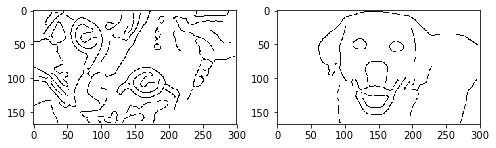

In [10]:
from skimage.feature import canny

cat_edges = canny(cgs, sigma=3)
dog_edges = canny(dgs, sigma=3)

fig = plt.figure(figsize = (8,4))
ax1 = fig.add_subplot(1,2, 1)
ax1.imshow(cat_edges, cmap='binary')
ax2 = fig.add_subplot(1,2, 2)
ax2.imshow(dog_edges, cmap='binary')

### Object detection 

C:\Program Files\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


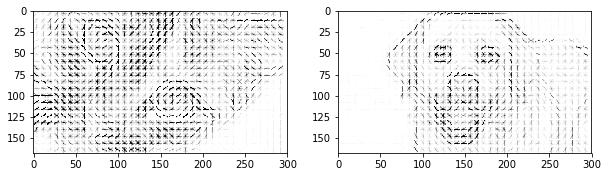

In [11]:
from skimage.feature import hog
from skimage import exposure

fd_cat, cat_hog = hog(cgs, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(3, 3), visualise=True)
fd_dog, dog_hog = hog(dgs, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(3, 3), visualise=True)

# rescaling intensity to get better plots
cat_hogs = exposure.rescale_intensity(cat_hog, in_range=(0, 0.04))
dog_hogs = exposure.rescale_intensity(dog_hog, in_range=(0, 0.04))

fig = plt.figure(figsize = (10,4))
ax1 = fig.add_subplot(1,2, 1)
ax1.imshow(cat_hogs, cmap='binary')
ax2 = fig.add_subplot(1,2, 2)
ax2.imshow(dog_hogs, cmap='binary')

In [12]:
print(fd_cat, fd_cat.shape)

[ 0.00288784  0.00301086  0.0255757  ...,  0.          0.          0.        ] (47880,)


### Localized feature extraction

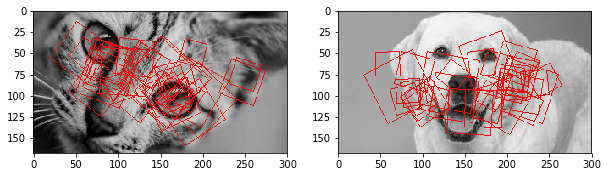

In [13]:
from mahotas.features import surf
import mahotas as mh

cat_mh = mh.colors.rgb2gray(cat)
dog_mh = mh.colors.rgb2gray(dog)

cat_surf = surf.surf(cat_mh, nr_octaves=8, nr_scales=16, initial_step_size=1, threshold=0.1, max_points=50)
dog_surf = surf.surf(dog_mh, nr_octaves=8, nr_scales=16, initial_step_size=1, threshold=0.1, max_points=54)

fig = plt.figure(figsize = (10,4))
ax1 = fig.add_subplot(1,2, 1)
ax1.imshow(surf.show_surf(cat_mh, cat_surf))
ax2 = fig.add_subplot(1,2, 2)
ax2.imshow(surf.show_surf(dog_mh, dog_surf))

In [14]:
cat_surf_fds = surf.dense(cat_mh, spacing=10)
dog_surf_fds = surf.dense(dog_mh, spacing=10)
cat_surf_fds.shape

(140, 64)

### Visual Bag of Words model

#### Engineering features from SURF feature descriptions with clustering

In [15]:
from sklearn.cluster import KMeans

k = 20
km = KMeans(k, n_init=100, max_iter=100)

surf_fd_features = np.array([cat_surf_fds, dog_surf_fds])
km.fit(np.concatenate(surf_fd_features))

vbow_features = []
for feature_desc in surf_fd_features:
    labels = km.predict(feature_desc)
    vbow = np.bincount(labels, minlength=k)
    vbow_features.append(vbow)

vbow_df = pd.DataFrame(vbow_features)
pd.concat([df, vbow_df], axis=1)

,Image,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,Cat,8,16,11,7,3,0,16,6,0,...,0,13,1,0,1,15,10,2,14,2
1,Dog,3,10,6,16,9,16,9,5,3,...,2,10,3,2,3,7,7,6,7,2


#### Trying out the VBOW pipeline on a new image

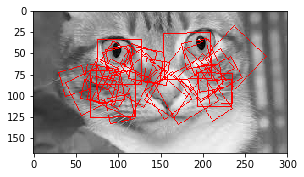

In [16]:
new_cat = io.imread('datasets/new_cat.png')
newcat_mh = mh.colors.rgb2gray(new_cat)
newcat_surf = surf.surf(newcat_mh, nr_octaves=8, nr_scales=16, initial_step_size=1, threshold=0.1, max_points=50)

fig = plt.figure(figsize = (10,4))
ax1 = fig.add_subplot(1,2, 1)
ax1.imshow(surf.show_surf(newcat_mh, newcat_surf))

In [17]:
new_surf_fds = surf.dense(newcat_mh, spacing=10)

labels = km.predict(new_surf_fds)
new_vbow = np.bincount(labels, minlength=k)
pd.DataFrame([new_vbow])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,9,5,11,0,9,4,19,9,0,16,0,7,3,0,0,7,20,3,16,2


In [18]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

eucdis = euclidean_distances(new_vbow.reshape(1,-1) , vbow_features)
cossim = cosine_similarity(new_vbow.reshape(1,-1) , vbow_features)

result_df = pd.DataFrame({'EuclideanDistance': eucdis[0],
              'CosineSimilarity': cossim[0]})
pd.concat([df, result_df], axis=1)

,Image,CosineSimilarity,EuclideanDistance
0,Cat,0.871609,21.260292
1,Dog,0.722096,30.000000


### Automated Feature Engineering with Deep Learning

In [19]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


#### Build a basic 2-layer CNN

In [55]:
model = Sequential()
model.add(Conv2D(4, (4, 4), input_shape=(168, 300, 3), activation='relu', 
                 kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(4, (4, 4), activation='relu', 
                kernel_initializer='glorot_uniform'))

#### Visualize the CNN architecture

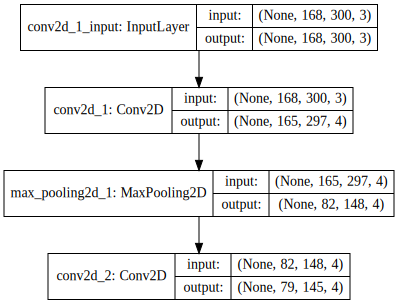

In [21]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, 
                 show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

#### Build functions to extract features from intermediate layers

In [56]:
first_conv_layer = K.function([model.layers[0].input, K.learning_phase()], 
                              [model.layers[0].output])
second_conv_layer = K.function([model.layers[0].input, K.learning_phase()], 
                               [model.layers[2].output])

#### Extract and visualize image representation features

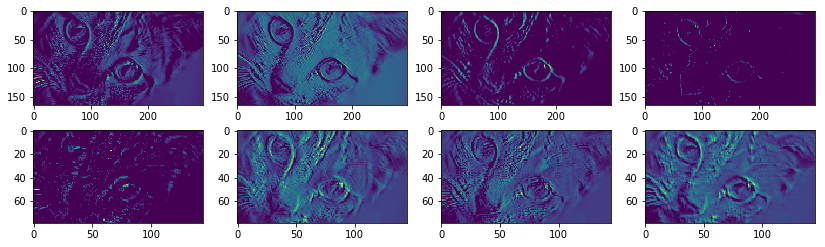

In [57]:
catr = cat.reshape(1, 168, 300,3)

# extract feaures 
first_conv_features = first_conv_layer([catr])[0][0]
second_conv_features = second_conv_layer([catr])[0][0]

# view feature representations
fig = plt.figure(figsize = (14,4))
ax1 = fig.add_subplot(2,4, 1)
ax1.imshow(first_conv_features[:,:,0])
ax2 = fig.add_subplot(2,4, 2)
ax2.imshow(first_conv_features[:,:,1])
ax3 = fig.add_subplot(2,4, 3)
ax3.imshow(first_conv_features[:,:,2])
ax4 = fig.add_subplot(2,4, 4)
ax4.imshow(first_conv_features[:,:,3])

ax5 = fig.add_subplot(2,4, 5)
ax5.imshow(second_conv_features[:,:,0])
ax6 = fig.add_subplot(2,4, 6)
ax6.imshow(second_conv_features[:,:,1])
ax7 = fig.add_subplot(2,4, 7)
ax7.imshow(second_conv_features[:,:,2])
ax8 = fig.add_subplot(2,4, 8)
ax8.imshow(second_conv_features[:,:,3])

In [60]:
sample_features = np.round(np.array(first_conv_features[:,:,1], dtype='float'), 2)
print(sample_features)
print(sample_features.shape)

[[ 26.05  25.48  24.85 ...,  37.35  37.38  36.5 ]
 [ 25.8   25.19  25.13 ...,  37.7   38.58  36.08]
 [ 25.32  24.85  24.5  ...,  36.8   36.68  35.23]
 ..., 
 [  4.47   3.31   3.72 ...,  31.74  31.64  32.5 ]
 [  4.01   4.24   3.02 ...,  31.74  31.64  32.5 ]
 [  4.67   3.53   3.68 ...,  31.74  31.64  32.5 ]]
(165, 297)


## Geospatial Data

- [Geospatial Feature Engineering and Visualization](https://www.kaggle.com/camnugent/geospatial-feature-engineering-and-visualization)
- [Intro to Geospatial Data using Python](https://github.com/SocialDataSci/Geospatial_Data_with_Python/blob/master/Intro%20to%20Geospatial%20Data%20with%20Python.ipynb)

# Feature Generation

Feature engineering is the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data.

**Feature Engineering is an art**
- Feature engineering is more of an art than a formal process. You need to know the domain you're working with to come up with reasonable features. If you're trying to predict credit card fraud, for example, study the most common fraud schemes, the main vulnerabilities in the credit card system, which behaviors are considered suspicious in an online transaction, etc. Then, look for data to represent those features, and test which combinations of features lead to the best results.

- Also, keep in mind that feature engineering uses different methods on different data types: categorical, numerical, spacial, text, audio, images, missing data, etc.

**Consider the model type**

- If you're using a linear model (such as linear regression), the hour feature might not be useful for predicting temperature since there's a non-linear relationship between hour (0-23) and temperature. Instead, you might create an is_night boolean feature that represents the hours 0-4 and 20-23.
- If you're using a non-linear model (such as decision trees), the hour feature might work well for predicting temperature since decision trees can learn from non-linear features.

## From indicator variables

These help the algorithm “focus” on what’s important by highlighting it beforehand.

**Indicator variable from thresholds:** Let’s say you’re studying alcohol preferences by U.S. consumers and your dataset has an age feature. You can create an indicator variable for age >= 21 to distinguish subjects who were over the legal drinking age.

**Indicator variable from multiple features:** You’re predicting real-estate prices and you have the features n_bedrooms and n_bathrooms. If houses with 2 beds and 2 baths command a premium as rental properties, you can create an indicator variable to flag them.

**Indicator variable for special events:** You’re modeling weekly sales for an e-commerce site. You can create two indicator variables for the weeks of Black Friday and Christmas.

**Indicator variable for groups of classes:** You’re analyzing website conversions and your dataset has the categorical feature traffic_source. You could create an indicator variable for paid_traffic by flagging observations with traffic source values of  "Facebook Ads" or "Google Adwords".


e.g.
- If your goal is to predict the temperature, you might use the datetime column to engineer an integer hour feature (0-23), since the hour of the day is a useful predictor of the temperature.
- If your goal is to predict the number of cars on the road, you might use the datetime column to engineer boolean is_weekend and is_holiday features (True/False), since those are useful predictors of traffic.
- Average time between past purchases
- Average amount of past purchases
- Maximum amount of past purchases
- Time elapsed since last purchase
- Total number of past purchases
- Average time between past outages
- Average number of affected servers in past outages
- Maximum number of affected servers in past outages
- Time elapsed since last outage
- Total number of past outages

## By combining variables

These help highlight interactions between two or more features.

Note: It's not recommend using an automated loop to create interactions for all your features. This leads to feature explosion.

**Sum of two features:** Let’s say you wish to predict revenue based on preliminary sales data. You have the features sales_blue_pens and sales_black_pens. You could sum those features if you only care about overall sales_pens.

**Difference between two features:** You have the features house_built_date and house_purchase_date. You can take their difference to create the feature house_age_at_purchase.

**Product of two features:** You’re running a pricing test, and you have the feature price and an indicator variable conversion. You can take their product to create the feature earnings.

**Quotient of two features:** You have a dataset of marketing campaigns with the features n_clicks and n_impressions. You can divide clicks by impressions to create  click_through_rate, allowing you to compare across campaigns of different volume.

## By changing a variable's representation

You should consider if you’d gain information by representing the same feature in a different way.

**Date and time features:** Let’s say you have the feature purchase_datetime. It might be more useful to extract purchase_day_of_week and purchase_hour_of_day. You can also aggregate observations to create features such as purchases_over_last_30_days.

**Numeric to categorical mappings:** You have the feature years_in_school. You might create a new feature grade with classes such as "Elementary School", "Middle School", and "High School".

**Grouping sparse classes:** You have a feature with many classes that have low sample counts. You can try grouping similar classes and then grouping the remaining ones into a single "Other" class.

**Creating dummy variables:** Depending on your machine learning implementation, you may need to manually transform categorical features into dummy variables. You should always do this after grouping sparse classes.

## By adding external data

This can lead to some of the biggest breakthroughs in performance.
For example, one way quantitative hedge funds perform research is by layering together different streams of financial data.

**Time series data:** The nice thing about time series data is that you only need one feature, some form of date, to layer in features from another dataset.
    
**External API’s:** There are plenty of API’s that can help you create features. For example, the Microsoft Computer Vision API can return the number of faces from an image.

**Geocoding:** Let’s say have you street_address, city, and state. Well, you can geocode them into latitude and longitude. This will allow you to calculate features such as local demographics (e.g. median_income_within_2_miles) with the help of another dataset.
    
**Other sources of the same data:** How many ways could you track a Facebook ad campaign? You might have Facebook’s own tracking pixel, Google Analytics, and possibly another third-party software. Each source can provide information that the others don’t track. Plus, any differences between the datasets could be informative (e.g. bot traffic that one source ignores while another source keeps).


In [ ]:
# TODO: Aggregate features into promising new features

In [ ]:
def generate_features(x, y):
    feature_dict = dict()
    feature_dict['target'] = y

    # create features here
    # numpy
    feature_dict['mean'] = np.mean(x)
    feature_dict['max'] = np.max(x)
    feature_dict['min'] = np.min(x)
    feature_dict['std'] = np.std(x)
    feature_dict['var'] = np.var(x)
    feature_dict['ptp'] = np.ptp(x)
    feature_dict['percentile_10'] = np.percentile(x, 10)
    feature_dict['percentile_20'] = np.percentile(x, 20)
    feature_dict['percentile_30'] = np.percentile(x, 30)
    feature_dict['percentile_40'] = np.percentile(x, 40)
    feature_dict['percentile_50'] = np.percentile(x, 50)
    feature_dict['percentile_60'] = np.percentile(x, 60)
    feature_dict['percentile_70'] = np.percentile(x, 70)
    feature_dict['percentile_80'] = np.percentile(x, 80)
    feature_dict['percentile_90'] = np.percentile(x, 90)

    # scipy
    feature_dict['skew'] = sp.stats.skew(x)
    feature_dict['kurtosis'] = sp.stats.kurtosis(x)
    feature_dict['kstat_1'] = sp.stats.kstat(x, 1)
    feature_dict['kstat_2'] = sp.stats.kstat(x, 2)
    feature_dict['kstat_3'] = sp.stats.kstat(x, 3)
    feature_dict['kstat_4'] = sp.stats.kstat(x, 4)
    feature_dict['moment_1'] = sp.stats.moment(x, 1)
    feature_dict['moment_2'] = sp.stats.moment(x, 2)
    feature_dict['moment_3'] = sp.stats.moment(x, 3)
    feature_dict['moment_4'] = sp.stats.moment(x, 4)
    train_eda["rooms_per_household"] = train_eda["BedroomAbvGr"]/train_eda["households"]
    train_eda["bedrooms_per_room"] = train_eda["total_bedrooms"]/train_eda["total_rooms"]
    train_eda["population_per_household"]=train_eda["population"]/train_eda["households"]

generate_features(features, label)

## Get stats on the dataset after feature engineering

In [ ]:
# Get the new correlation matrix after feature engineering
corr_matrix = train_eda.corr()
corr_matrix[label_col].sort_values(ascending=False)[:5]

In [ ]:
# Describe() with the newly generated features
train_eda.describe()

In [ ]:
# Plot newly created features after feature engineering vs label
train_eda.plot(kind="scatter", x=label_col, y="GarageArea", alpha=0.1, figsize=(15,10))
plt.axis([0, 400000, 0, 1200])

In [ ]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

In [ ]:
# plot distributions of the newly engineered features.

# distribution of new features, grouped by value of corresponding target values
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[202:]
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

In [ ]:
# distribution of new features values for train and test
features = train_df.columns.values[202:]
plot_new_feature_distribution(train_df, test_df, 'train', 'test', features)

# Feature Selection

## Threshold based methods


Limiting features in bag of word based models

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0.1, max_df=0.85, max_features=2000)
cv

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.85, max_features=2000, min_df=0.1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

### Variance based thresholding

In [3]:
df = pd.read_csv('datasets/Pokemon.csv')
poke_gen = pd.get_dummies(df['Generation'])
poke_gen.head()

,Gen 1,Gen 2,Gen 3,Gen 4,Gen 5,Gen 6
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0


In [4]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=.15)
vt.fit(poke_gen)

VarianceThreshold(threshold=0.15)

In [5]:
pd.DataFrame({'variance': vt.variances_,
              'select_feature': vt.get_support()},
            index=poke_gen.columns).T

,Gen 1,Gen 2,Gen 3,Gen 4,Gen 5,Gen 6
select_feature,True,False,True,False,True,False
variance,0.164444,0.114944,0.16,0.128373,0.163711,0.0919937


In [6]:
poke_gen_subset = poke_gen.iloc[:,vt.get_support()].head()
poke_gen_subset

,Gen 1,Gen 3,Gen 5
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


## Statistical Methods

In [7]:
from sklearn.datasets import load_breast_cancer

bc_data = load_breast_cancer()
bc_features = pd.DataFrame(bc_data.data, columns=bc_data.feature_names)
bc_classes = pd.DataFrame(bc_data.target, columns=['IsMalignant'])

# build featureset and response class labels 
bc_X = np.array(bc_features)
bc_y = np.array(bc_classes).T[0]
print('Feature set shape:', bc_X.shape)
print('Response class shape:', bc_y.shape)

Feature set shape: (569, 30)
Response class shape: (569,)


In [8]:
np.set_printoptions(threshold=30)
print('Feature set data [shape: '+str(bc_X.shape)+']')
print(np.round(bc_X, 2), '\n')
print('Feature names:')
print(np.array(bc_features.columns), '\n')
print('Predictor Class label data [shape: '+str(bc_y.shape)+']')
print(bc_y, '\n')
print('Predictor name:', np.array(bc_classes.columns))
np.set_printoptions(threshold=pt)

Feature set data [shape: (569, 30)]
[[  17.99   10.38  122.8  ...,    0.27    0.46    0.12]
 [  20.57   17.77  132.9  ...,    0.19    0.28    0.09]
 [  19.69   21.25  130.   ...,    0.24    0.36    0.09]
 ..., 
 [  16.6    28.08  108.3  ...,    0.14    0.22    0.08]
 [  20.6    29.33  140.1  ...,    0.26    0.41    0.12]
 [   7.76   24.54   47.92 ...,    0.      0.29    0.07]] 

Feature names:
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension'] 

Predictor Class label data [shape: (569,)]
[0 

In [9]:
from sklearn.feature_selection import chi2, SelectKBest

skb = SelectKBest(score_func=chi2, k=15)
skb.fit(bc_X, bc_y)

SelectKBest(k=15, score_func=<function chi2 at 0x00000166BF43A7B8>)

In [10]:
feature_scores = [(item, score) for item, score in zip(bc_data.feature_names, skb.scores_)]
sorted(feature_scores, key=lambda x: -x[1])[:10]

[('worst area', 112598.43156405364),
 ('mean area', 53991.655923750892),
 ('area error', 8758.5047053344697),
 ('worst perimeter', 3665.0354163405909),
 ('mean perimeter', 2011.1028637679051),
 ('worst radius', 491.68915743332195),
 ('mean radius', 266.10491719517802),
 ('perimeter error', 250.57189635982184),
 ('worst texture', 174.44939960571074),
 ('mean texture', 93.897508098633352)]

In [11]:
select_features_kbest = skb.get_support()
feature_names_kbest = bc_data.feature_names[select_features_kbest]
feature_subset_df = bc_features[feature_names_kbest]
bc_SX = np.array(feature_subset_df)
print(bc_SX.shape)
print(feature_names_kbest)

(569, 15)
['mean radius' 'mean texture' 'mean perimeter' 'mean area' 'mean concavity'
 'radius error' 'perimeter error' 'area error' 'worst radius'
 'worst texture' 'worst perimeter' 'worst area' 'worst compactness'
 'worst concavity' 'worst concave points']


In [12]:
np.round(feature_subset_df.iloc[20:25], 2)

,mean radius,mean texture,mean perimeter,mean area,mean concavity,radius error,perimeter error,area error,worst radius,worst texture,worst perimeter,worst area,worst compactness,worst concavity,worst concave points
20,13.08,15.71,85.63,520.0,0.05,0.19,1.38,14.67,14.50,20.49,96.09,630.5,0.28,0.19,0.07
21,9.50,12.44,60.34,273.9,0.03,0.28,1.91,15.70,10.23,15.66,65.13,314.9,0.11,0.09,0.06
22,15.34,14.26,102.50,704.4,0.21,0.44,3.38,44.91,18.07,19.08,125.10,980.9,0.60,0.63,0.24
23,21.16,23.04,137.20,1404.0,0.11,0.69,4.30,93.99,29.17,35.59,188.00,2615.0,0.26,0.32,0.20
24,16.65,21.38,110.00,904.6,0.15,0.81,5.46,102.60,26.46,31.56,177.00,2215.0,0.36,0.47,0.21


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# build logistic regression model
lr = LogisticRegression()

# evaluating accuracy for model built on full featureset
full_feat_acc = np.average(cross_val_score(lr, bc_X, bc_y, scoring='accuracy', cv=5))
# evaluating accuracy for model built on selected featureset
sel_feat_acc = np.average(cross_val_score(lr, bc_SX, bc_y, scoring='accuracy', cv=5))

print('Model accuracy statistics with 5-fold cross validation')
print('Model accuracy with complete feature set', bc_X.shape, ':', full_feat_acc)
print('Model accuracy with selected feature set', bc_SX.shape, ':', sel_feat_acc)

Model accuracy statistics with 5-fold cross validation
Model accuracy with complete feature set (569, 30) : 0.950904193921
Model accuracy with selected feature set (569, 15) : 0.952643324356


## Recursive Feature Elimination

In [14]:
from sklearn.feature_selection import RFE

lr = LogisticRegression()
rfe = RFE(estimator=lr, n_features_to_select=15, step=1)
rfe.fit(bc_X, bc_y)

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=15, step=1, verbose=0)

In [15]:
select_features_rfe = rfe.get_support()
feature_names_rfe = bc_data.feature_names[select_features_rfe]
print(feature_names_rfe)

['mean radius' 'mean texture' 'mean perimeter' 'mean smoothness'
 'mean concavity' 'mean concave points' 'mean symmetry' 'texture error'
 'worst radius' 'worst texture' 'worst smoothness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [16]:
set(feature_names_kbest) & set(feature_names_rfe)

{'mean concavity',
 'mean perimeter',
 'mean radius',
 'mean texture',
 'worst concave points',
 'worst concavity',
 'worst radius',
 'worst texture'}

## Model based selection

In [17]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(bc_X, bc_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [18]:
importance_scores = rfc.feature_importances_
feature_importances = [(feature, score) for feature, score in zip(bc_data.feature_names, importance_scores)]
sorted(feature_importances, key=lambda x: -x[1])[:10]

[('worst concave points', 0.22465186401289805),
 ('worst area', 0.22183657032316897),
 ('mean concave points', 0.18192574025833769),
 ('worst perimeter', 0.099521838900566054),
 ('worst radius', 0.084068507192381611),
 ('worst texture', 0.02243708745933972),
 ('mean perimeter', 0.020073882937172081),
 ('worst smoothness', 0.014608966775322443),
 ('mean radius', 0.01374196961657885),
 ('worst concavity', 0.011340255118074721)]

## Feature extraction using dimensionality reduction

In [19]:
# center the feature set
bc_XC = bc_X - bc_X.mean(axis=0)

# decompose using SVD
U, S, VT = np.linalg.svd(bc_XC)

# get principal components
PC = VT.T

# get first 3 principal components
PC3 = PC[:, 0:3]
PC3.shape

(30, 3)

In [20]:
# reduce feature set dimensionality 
np.round(bc_XC.dot(PC3), 2)

array([[-1160.14,  -293.92,   -48.58],
       [-1269.12,    15.63,    35.39],
       [ -995.79,    39.16,     1.71],
       ..., 
       [ -314.5 ,    47.55,    10.44],
       [-1124.86,    34.13,    19.74],
       [  771.53,   -88.64,   -23.89]])

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(bc_X)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [22]:
pca.explained_variance_ratio_

array([ 0.98204467,  0.01617649,  0.00155751])

In [23]:
bc_pca = pca.transform(bc_X)
np.round(bc_pca, 2)

array([[ 1160.14,  -293.92,    48.58],
       [ 1269.12,    15.63,   -35.39],
       [  995.79,    39.16,    -1.71],
       ..., 
       [  314.5 ,    47.55,   -10.44],
       [ 1124.86,    34.13,   -19.74],
       [ -771.53,   -88.64,    23.89]])

In [24]:
np.average(cross_val_score(lr, bc_pca, bc_y, scoring='accuracy', cv=5))

0.92808003078106949

# Select and train a model

**Fixing Overfitting:**
- To simplify the model by selecting one with fewer parameters (e.g., a linear model rather than a high-degree polynomial model), by reducing the number of attributes in the training data or by constraining the model
- To gather more training data
- To reduce the noise in the training data (e.g., fix data errors and remove outliers)

**Fixing Underfitting:**
- Selecting a more powerful model, with more parameters
- Feeding better features to the learning algorithm (feature engineering)
- Reducing the constraints on the model (e.g., reducing the regularization hyperparameter)

## Advice on model training

**Performance Comparision of Boosting algorithms**

- Default parameters of CatBoost usually outperform tuned parameters of XGBoost and LightGBM.
- PS: don't trust other people's benchmarks. Prepare your own benchmarks.
- CatBoost is the best in terms of AUC but only if you manually specify to it which features are categorical.
- CatBoost's (without categorical features) prediction time was faster than XGBoost, which was faster than LightGBM. CatBoost was faster because they use oblivious trees which can do many more optimizations.
- CatBoost's training time much slower than XGBoost or LightGBM (which means you can optimize your hyperparameters quite fast with many iterations, in the time that CatBoost would finish 1 iteration). LightGBM is faster than XGBoost (wasn't measured against XGBoost with the histogram method though)

<img src="images/boosting_algorithms.png" width=50%>

## Apply transformation pipeline to test data

In [ ]:
# apply the full preprocessing pipeline on a test data
test_prepared = full_pipeline.transform(test_features)

## Train the models

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(features_prepared, labels)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(features_prepared, labels)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(features_prepared, labels)

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)

## Get the predictions

In [ ]:
# get predictions
lin_preds = lin_reg.predict(test_prepared)
tree_preds = tree_reg.predict(test_prepared)
forest_preds = forest_reg.predict(test_prepared)
svr_preds = svm_reg.predict(test_prepared)

## Get the score

In [ ]:
# get score
# mse
from sklearn.metrics import mean_squared_error

lin_rmse = np.sqrt(mean_squared_error(test_labels, lin_preds))
tree_rmse = np.sqrt(mean_squared_error(test_labels, tree_preds))
forest_rmse = np.sqrt(mean_squared_error(test_labels, forest_preds))
svr_rmse = np.sqrt(mean_squared_error(test_labels, svr_preds))

In [ ]:
# mae
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(test_labels, lin_preds)
tree_mae = mean_absolute_error(test_labels, tree_preds)
forest_mae = mean_absolute_error(test_labels, forest_preds)
svr_mae = mean_absolute_error(test_labels, svr_preds)

# Fine-tune model

Unless there are very few hyperparameter values to explore, prefer random search over grid search. If training is very long, you may prefer a Bayesian optimization approach.

## GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(features_prepared, labels)

In [ ]:
# best hyperparameter combination found
grid_search.best_params_

In [ ]:
# best estimator combination found
grid_search.best_estimator_

In [ ]:
# cross validation results
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
# cross validation results - better display
pd.DataFrame(grid_search.cv_results_)

### Explore preparation options using GridSearchCV

In [ ]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(features, labels)

In [ ]:
grid_search_prep.best_params_

## RandomizedSearch

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

In [ ]:
# best hyperparameter combination found
rnd_search.best_params_

In [ ]:
# best estimator combination found
rnd_search.best_estimator_

In [ ]:
# cross validation results
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

## Ensemble Methods

Another way to fine-tune your system is to try to combine the models that perform best. The group (or “ensemble”) will often perform better than the best individual model (just like Random Forests perform better than the individual Decision Trees they rely on), especially if the individual models make very different types of errors. 

# Inspecting the best model

## Error Analysis (Post-Modeling)

The final type of feature engineering we’ll cover falls under a process called error analysis. This is performed after training your first model.

Error analysis is a broad term that refers to analyzing the misclassified or high error observations from your model and deciding on your next steps for improvement.

Possible next steps include collecting more data, splitting the problem apart, or engineering new features that address the errors. To use error analysis for feature engineering, you’ll need to understand why your model missed its mark.

Here’s how:

**Start with larger errors:** Error analysis is typically a manual process. You won’t have time to scrutinize every observation. We recommend starting with those that had higher error scores. Look for patterns that you can formalize into new features.

**Segment by classes:** Another technique is to segment your observations and compare the average error within each segment. You can try creating indicator variables for the segments with the highest errors.

**Unsupervised clustering:** If you have trouble spotting patterns, you can run an unsupervised clustering algorithm on the misclassified observations. We don’t recommend blindly using those clusters as a new feature, but they can make it easier to spot patterns. Remember, the goal is to understand why observations were misclassified.

**Ask colleagues or domain experts:** This is a great complement to any of the other three techniques. Asking a domain expert is especially useful if you’ve identified a pattern of poor performance (e.g. through segmentations) but don’t yet understand why.

## Feature Importances

Feature importances indicate the relative importance of each attribute for making accurate predictions

In [ ]:
# feature importances
feature_importances = grid_search.best_estimator_.feature_importances_

In [ ]:
# display these importance scores next to their corresponding attribute names
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

In [ ]:
# Plot feature importances
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

With this information, you may want to try removing some of the less useful features (e.g., if only one or a few categories of categorical variables are really useful, you could try removing the others).

You should also look at the specific errors that your system makes, then try to understand why it makes them and what could fix the problem (adding extra features or, on the contrary, getting rid of uninformative ones, cleaning up outliers, etc.).

## Explain model with SHAP Values

### Tree ensemble example with TreeExplainer (XGBoost/LightGBM/CatBoost/scikit-learn models)

While SHAP values can explain the output of any machine learning model, we have developed a high-speed exact algorithm for tree ensemble methods ([Tree SHAP arXiv paper](https://arxiv.org/abs/1802.03888)). Fast C++ implementations are supported for *XGBoost*, *LightGBM*, *CatBoost*, and *scikit-learn* tree models:

```python
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
X,y = shap.datasets.boston()
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])
```

<p align="center">
  <img width="811" src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/boston_instance.png" />
</p>

<!--If you want to use `matplotlib` backend in place of javascript, you can do so as shown below. You can also rotate the feature names using `text_rotation` parameter, if your dataset has really long feature names.
```python
%matplotlib inline
import xgboost
import shap

# train XGBoost model
X,y = shap.datasets.boston()

model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
# visualize the first prediction's explanation using matplotlib (no javascript needed)
# rotate the annotations so that they are legible when you have really long attribute names
shap.force_plot(
    explainer.expected_value, 
    shap_values[0, :], 
    X.iloc[0, :], 
    matplotlib=True, 
    text_rotation=30, 
    show=True
)
```

<p align="center">
  <img width="811" src="https://raw.githubusercontent.com/vatsan/shap/master/docs/artwork/force_plot_matplotlib_rotate.png" />
</p>-->

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue (these force plots are introduced in our [Nature BME paper](https://www.nature.com/articles/s41551-018-0304-0)).

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

```python
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)
```

<p align="center">
  <img width="811" src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/boston_dataset.png" />
</p>

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in predicted house price as RM (the average number of rooms per house in an area) changes. Vertical dispersion at a single value of RM represents interaction effects with other features. To help reveal these interactions `dependence_plot` automatically selects another feature for coloring. In this case coloring by RAD (index of accessibility to radial highways) highlights that the average number of rooms per house has less impact on home price for areas with a high RAD value.

```python
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("RM", shap_values, X)
```

<p align="center">
  <img width="544" src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/boston_dependence_plot.png" />
</p>


To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). This reveals for example that a high LSTAT (% lower status of the population) lowers the predicted home price.

```python
# summarize the effects of all the features
shap.summary_plot(shap_values, X)
```

<p align="center">
  <img width="483" src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/boston_summary_plot.png" />
</p>

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):

```python
shap.summary_plot(shap_values, X, plot_type="bar")
```

<p align="center">
  <img width="470" src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/boston_summary_plot_bar.png" />
</p>

### Deep learning example with DeepExplainer (TensorFlow/Keras models)

Deep SHAP is a high-speed approximation algorithm for SHAP values in deep learning models that builds on a connection with [DeepLIFT](https://arxiv.org/abs/1704.02685) described in the SHAP NIPS paper. The implementation here differs from the original DeepLIFT by using a distribution of background samples instead of a single reference value, and using Shapley equations to linearize components such as max, softmax, products, divisions, etc. Note that some of these enhancements have also been since integrated into DeepLIFT. TensorFlow models and Keras models using the TensorFlow backend are supported (there is also preliminary support for PyTorch):

```python
# ...include code from https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

import shap
import numpy as np

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:5])

# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:5])
```

<p align="center">
  <img width="820" src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/mnist_image_plot.png" />
</p>

The plot above explains ten outputs (digits 0-9) for four different images. Red pixels increase the model's output while blue pixels decrease the output. The input images are shown on the left, and as nearly transparent grayscale backings behind each of the explanations. The sum of the SHAP values equals the difference between the expected model output (averaged over the background dataset) and the current model output. Note that for the 'zero' image the blank middle is important, while for the 'four' image the lack of a connection on top makes it a four instead of a nine.


### Deep learning example with GradientExplainer (TensorFlow/Keras/PyTorch models)

Expected gradients combines ideas from [Integrated Gradients](https://arxiv.org/abs/1703.01365), SHAP, and [SmoothGrad](https://arxiv.org/abs/1706.03825) into a single expected value equation. This allows an entire dataset to be used as the background distribution (as opposed to a single reference value) and allows local smoothing. If we approximate the model with a linear function between each background data sample and the current input to be explained, and we assume the input features are independent then expected gradients will compute approximate SHAP values. In the example below we have explained how the 7th intermediate layer of the VGG16 ImageNet model impacts the output probabilities.

```python
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)
```

<p align="center">
  <img width="500" src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/gradient_imagenet_plot.png" />
</p>

Predictions for two input images are explained in the plot above. Red pixels represent positive SHAP values that increase the probability of the class, while blue pixels represent negative SHAP values the reduce the probability of the class. By using `ranked_outputs=2` we explain only the two most likely classes for each input (this spares us from explaining all 1,000 classes).

### Model agnostic example with KernelExplainer (explains any function)

Kernel SHAP uses a specially-weighted local linear regression to estimate SHAP values for any model. Below is a simple example for explaining a multi-class SVM on the classic iris dataset.

```python
import sklearn
import shap
from sklearn.model_selection import train_test_split

# print the JS visualization code to the notebook
shap.initjs()

# train a SVM classifier
X_train,X_test,Y_train,Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train, Y_train)

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")
```
<p align="center">
  <img width="810" src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/iris_instance.png" />
</p>

The above explanation shows four features each contributing to push the model output from the base value (the average model output over the training dataset we passed) towards zero. If there were any features pushing the class label higher they would be shown in red.

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset. This is exactly what we do below for all the examples in the iris test set:

```python
# plot the SHAP values for the Setosa output of all instances
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="logit")
```
<p align="center">
  <img width="813" src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/iris_dataset.png" />
</p>

### SHAP Interaction Values

SHAP interaction values are a generalization of SHAP values to higher order interactions. Fast exact computation of pairwise interactions are implemented for tree models with `shap.TreeExplainer(model).shap_interaction_values(X)`. This returns a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. These values often reveal interesting hidden relationships, such as how the increased risk of death peaks for men at age 60 (see the NHANES notebook for details):

<p align="center">
  <img width="483" src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/nhanes_age_sex_interaction.png" />
</p>

### Sample notebooks

The notebooks below demonstrate different use cases for SHAP. Look inside the notebooks directory of the repository if you want to try playing with the original notebooks yourself.

#### TreeExplainer

An implementation of Tree SHAP, a fast and exact algorithm to compute SHAP values for trees and ensembles of trees.

- [**NHANES survival model with XGBoost and SHAP interaction values**](https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html) - Using mortality data from 20 years of followup this notebook demonstrates how to use XGBoost and `shap` to uncover complex risk factor relationships.

- [**Census income classification with LightGBM**](https://slundberg.github.io/shap/notebooks/Census%20income%20classification%20with%20LightGBM.html) - Using the standard adult census income dataset, this notebook trains a gradient boosting tree model with LightGBM and then explains predictions using `shap`.

- [**League of Legends Win Prediction with XGBoost**](https://slundberg.github.io/shap/notebooks/League%20of%20Legends%20Win%20Prediction%20with%20XGBoost.html) - Using a Kaggle dataset of 180,000 ranked matches from League of Legends we train and explain a gradient boosting tree model with XGBoost to predict if a player will win their match.

#### DeepExplainer

An implementation of Deep SHAP, a faster (but only approximate) algorithm to compute SHAP values for deep learning models that is based on connections between SHAP and the DeepLIFT algorithm.

- [**MNIST Digit classification with Keras**](https://slundberg.github.io/shap/notebooks/deep_explainer/Front%20Page%20DeepExplainer%20MNIST%20Example.html) - Using the MNIST handwriting recognition dataset, this notebook trains a neural network with Keras and then explains predictions using `shap`.

- [**Keras LSTM for IMDB Sentiment Classification**](https://slundberg.github.io/shap/notebooks/deep_explainer/Keras%20LSTM%20for%20IMDB%20Sentiment%20Classification.html) - This notebook trains an LSTM with Keras on the IMDB text sentiment analysis dataset and then explains predictions using `shap`. 

#### GradientExplainer

An implementation of expected gradients to approximate SHAP values for deep learning models. It is based on connections between SHAP and the Integrated Gradients algorithm. GradientExplainer is slower than DeepExplainer and makes different approximation assumptions.

- [**Explain an Intermediate Layer of VGG16 on ImageNet**](https://slundberg.github.io/shap/notebooks/gradient_explainer/Explain%20an%20Intermediate%20Layer%20of%20VGG16%20on%20ImageNet.html) - This notebook demonstrates how to explain the output of a pre-trained VGG16 ImageNet model using an internal convolutional layer.

#### LinearExplainer

For a linear model with independent features we can analytically compute the exact SHAP values. We can also account for feature correlation if we are willing to estimate the feature covaraince matrix. LinearExplainer supports both of these options.

- [**Sentiment Analysis with Logistic Regression**](https://slundberg.github.io/shap/notebooks/linear_explainer/Sentiment%20Analysis%20with%20Logistic%20Regression.html) - This notebook demonstrates how to explain a linear logistic regression sentiment analysis model.

#### KernelExplainer

An implementation of Kernel SHAP, a model agnostic method to estimate SHAP values for any model. Because it makes not assumptions about the model type, KernelExplainer is slower than the other model type specific algorithms.

- [**Census income classification with scikit-learn**](https://slundberg.github.io/shap/notebooks/Census%20income%20classification%20with%20scikit-learn.html) - Using the standard adult census income dataset, this notebook trains a k-nearest neighbors classifier using scikit-learn and then explains predictions using `shap`.

- [**ImageNet VGG16 Model with Keras**](https://slundberg.github.io/shap/notebooks/ImageNet%20VGG16%20Model%20with%20Keras.html) - Explain the classic VGG16 convolutional nerual network's predictions for an image. This works by applying the model agnostic Kernel SHAP method to a super-pixel segmented image.

- [**Iris classification**](https://slundberg.github.io/shap/notebooks/Iris%20classification%20with%20scikit-learn.html) - A basic demonstration using the popular iris species dataset. It explains predictions from six different models in scikit-learn using `shap`.

### Methods Unified by SHAP

1. *LIME:* Ribeiro, Marco Tulio, Sameer Singh, and Carlos Guestrin. "Why should i trust you?: Explaining the predictions of any classifier." Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. ACM, 2016.

2. *Shapley sampling values:* Strumbelj, Erik, and Igor Kononenko. "Explaining prediction models and individual predictions with feature contributions." Knowledge and information systems 41.3 (2014): 647-665.

3. *DeepLIFT:* Shrikumar, Avanti, Peyton Greenside, and Anshul Kundaje. "Learning important features through propagating activation differences." arXiv preprint arXiv:1704.02685 (2017).

4. *QII:* Datta, Anupam, Shayak Sen, and Yair Zick. "Algorithmic transparency via quantitative input influence: Theory and experiments with learning systems." Security and Privacy (SP), 2016 IEEE Symposium on. IEEE, 2016.

5. *Layer-wise relevance propagation:* Bach, Sebastian, et al. "On pixel-wise explanations for non-linear classifier decisions by layer-wise relevance propagation." PloS one 10.7 (2015): e0130140.

6. *Shapley regression values:* Lipovetsky, Stan, and Michael Conklin. "Analysis of regression in game theory approach." Applied Stochastic Models in Business and Industry 17.4 (2001): 319-330.

7. *Tree interpreter:* Saabas, Ando. Interpreting random forests. http://blog.datadive.net/interpreting-random-forests/

### Citations

The algorithms and visualizations used in this package came primarily out of research in [Su-In Lee's lab](https://suinlee.cs.washington.edu) at the University of Washington. If you use SHAP in your research we would appreciate a citation to the appropriate paper(s):

- For general use of SHAP you can read/cite our [NeurIPS paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) ([bibtex](https://raw.githubusercontent.com/slundberg/shap/master/docs/references/shap_nips.bib)). 
- For TreeExplainer you can (for now) read/cite our [arXiv paper](https://arxiv.org/abs/1802.03888) ([bibtex](https://raw.githubusercontent.com/slundberg/shap/master/docs/references/treeshap_arxiv.bib)).
- For `force_plot` visualizations and medical applications you can read/cite our [Nature Biomedical Engineering paper](https://www.nature.com/articles/s41551-018-0304-0) ([bibtex](https://raw.githubusercontent.com/slundberg/shap/master/docs/references/nature_bme.bib); [free access](https://rdcu.be/baVbR)).

<img height="1" width="1" style="display:none" src="https://www.facebook.com/tr?id=189147091855991&ev=PageView&noscript=1" />


## Train model with most important k features

In [ ]:
# adding a transformer in the preparation pipeline to select only the most important attributes
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [ ]:
k = 5

# get the indices of the top k features:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

# get the names of the top k features:
np.array(attributes)[top_k_feature_indices]

# double check that these are indeed the top k features
sorted(zip(feature_importances, attributes), reverse=True)[:k]

In [ ]:
# create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])
features_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(features)

In [ ]:
housing_prepared_top_k_features[0:3]

## Evaluate the best model

In [ ]:
# get the best model
final_model = grid_search.best_estimator_

# get the predictors and the labels from your test set
X_test = strat_test_set.drop("label_column", axis=1)
y_test = strat_test_set["label_column"].copy()

# run your full_pipeline to transform the data (call transform(), not fit_transform(), you do not want to fit the test set!)
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

# evaluate the final model on the test set
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
final_rmse

In some cases, such a point estimate of the generalization error will not be quite enough to convince you to launch: what if it is just 0.1% better than the model currently in production? You might want to have an idea of how precise this estimate is. For this, you can compute a 95% confidence interval for the generalization error using scipy.stats.t.interval():

In [ ]:
# compute a 95% confidence interval for the test RMSE:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

In [ ]:
# or, compute the interval manually like this:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

# Alternatively, use z-scores rather than t-scores:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

# Misc

## full pipeline with both preparation and prediction

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(features, labels)
full_pipeline_with_predictor.predict(predict_some_data)

## Save model

In [ ]:
my_model = full_pipeline_with_predictor
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF

## Load model

In [ ]:
my_model_loaded = joblib.load("my_model.pkl") # DIFF

# Present solution

1. Document what you have done.
2. Create a nice presentation.
    - Make sure you highlight the big picture first.
3. Explain why your solution achieves the business objective.
4. Don’t forget to present interesting points you noticed along the way.
    - Describe what worked and what did not.
    - List your assumptions and your system’s limitations.
5. Ensure your key findings are communicated through beautiful visualizations or easy-to-remember statements (e.g., “the median income is the number-one predictor of housing prices”).

# Launch!

1. Get your solution ready for production (plug into production data inputs, write unit tests, etc.).
2. Write monitoring code to check your system’s live performance at regular intervals and trigger alerts when it drops.
    - Beware of slow degradation too: models tend to “rot” as data evolves.
    - Measuring performance may require a human pipeline (e.g., via a crowdsourcing service).
    - Also monitor your inputs’ quality (e.g., a malfunctioning sensor sending random values, or another team’s output becoming stale). This is particularly important for online learning systems.
3. Retrain your models on a regular basis on fresh data (automate as much as possible).